# Interpreting ML Model

- 부분의존도그림(Partial dependence plot, PDP)을 시각화하고 해석할 수 있습니다.
- 개별 예측 사례를 Shap value plots을 사용해 설명할 수 있습니다.

- [Partial Dependence Plot (PDP) in Python](https://www.youtube.com/watch?v=21QAKe2PDkk)
    - model-agnostic 방법이 무엇인가요?

#### 학습을 진행하기 전에 다음 페이지를 읽어 보세요.
- [Kaggle: Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Kaggle: Shap Values](https://www.kaggle.com/dansbecker/shap-values)


#### 이번 모듈에서 추가적으로 사용하는 라이브러리는 다음과 같습니다. 설치를 확인해 주세요.

- [**pdpbox**](https://github.com/SauceCat/PDPbox)
- [**shap**](https://github.com/slundberg/shap)

패키지 인스톨

pdpbox: ```$conda install -c conda-forge pdpbox```

shap: ```$conda install -c conda-forge shap```

In [1]:
%%capture

# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Partial Dependence Plots(PDP)

여러분은 높은 성능을 가지는 모델을 만들기 위해 랜덤포레스트, 부스팅과 같은 앙상블 모델을 많이 사용하게 됩니다. 하지만 이렇게 복잡도가 높은 모델들은 선형모델에 비해서 해석하기가 어렵습니다.

즉 다음과 같은 관계가 성립합니다.
- 복잡한 모델 -> 이해하기 어렵지만 성능이 좋다.
- 단순한 모델 -> 이해하기 쉽지만 성능이 부족하다.

예를들어 랜덤포래스트, 부스팅의 경우 쉽게 특성중요도(feature importance) 값을 얻을 수 있는데, 이것을 통해서 우리가 알 수 있는 것은 어떤 특성들이 모델의 성능에 **중요**하다, 많이 쓰인다는 정보 뿐입니다. 특성의 값에 따라서 타겟값이 증가/감소하느냐와 같은 **어떻게 영향을 미치는지**에 대한 정보를 알 수 없습니다. 

이때 부분의존도그림(Partial dependence plots, PDP)을 사용하면 관심있는 특성들이 타겟에 어떻게 영향을 주는지 쉽게 파악할 수 있습니다.

[Lending Club](https://www.lendingclub.com/site/home) 에서 샘플링한 데이터세트를 사용해 진행 하겠습니다.

In [4]:
import pandas as pd

# Kaggle 데이터세트에서 10% 샘플링된 데이터입니다.
## Source: https://www.kaggle.com/wordsforthewise/lending-club
## 10% of expired loans (loan_status: ['Fully Paid' and 'Charged Off'])
## grades A-D
## term ' 36 months'

df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/lending_club/lending_club_sampled.csv')
df['issue_d'] = pd.to_datetime(df['issue_d'], infer_datetime_format=True)

# issue_d로 정렬
df = df.set_index('issue_d').sort_index()

df['interest_rate'] = df['int_rate'].astype(float)
df['monthly_debts'] = df['annual_inc'] / 12 * df['dti'] / 100

# 152 특성 중 6특성만 사용
columns = ['annual_inc', # 연수입
           'fico_range_high', # 신용점수 
           'funded_amnt', # 대출
           'title', # 대출 목적
           'monthly_debts', # 월간 부채
           'interest_rate'] # 이자율

df = df[columns]
df = df.dropna()

# 마지막 10,000 대출은 테스트셋
# 테스트셋 전 10,000 대출이 검증셋
# 나머지는 학습셋
test = df[-10000:]
val = df[-20000:-10000]
train = df[:-20000]

In [5]:
df.columns

Index(['annual_inc', 'fico_range_high', 'funded_amnt', 'title',
       'monthly_debts', 'interest_rate'],
      dtype='object')

In [6]:
test.shape, val.shape, train.shape

((10000, 6), (10000, 6), (76408, 6))

In [7]:
# 타겟은 이자율
target = 'interest_rate' 
features = df.columns.drop('interest_rate')

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

/usr/local/lib/python3.9/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.9/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.9/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


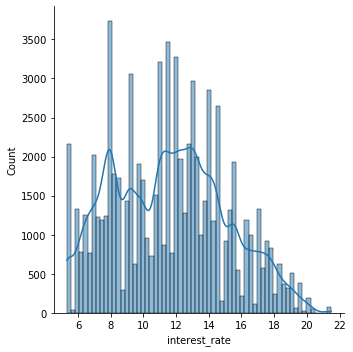

In [8]:
# 타겟이 약간 right skewed 되어 있으나 큰 문제는 아닙니다.
%matplotlib inline
import seaborn as sns
sns.displot(y_train, kde=True);

### 선형회귀 학습

In [9]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
from category_encoders import TargetEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

linear = make_pipeline(
    TargetEncoder(),  
    LinearRegression()
)

linear.fit(X_train, y_train)
print('R^2', linear.score(X_val, y_val))

R^2 0.17022988411414786


### 선형회귀 결과 해석

In [11]:
# 회귀계수
coefficients = linear.named_steps['linearregression'].coef_
pd.Series(coefficients, features)

annual_inc        -0.000005
fico_range_high   -0.052555
funded_amnt        0.000023
title              1.191943
monthly_debts      0.000015
dtype: float64

선형모델에서는 연수입(annual_inc) 이 이자율에 얼마나 영향을 주는지 알 수 있습니다.
- $10k 더 벌 수록 0.05 이율이 줄어듭니다.

In [12]:
-0.000005 * 10000

-0.05

선형모델에서 신용점수(fico_range_high) 는 얼마나 영향을 줄까요?
- 신용점수가 100 point 오를 때마다 5% 가까이 이율이 줄어든다고 예측합니다.

In [13]:
-0.052805 * 100

-5.2805

### 그래디언트 부스팅으로 학습을 진행해 보겠습니다.

In [14]:
from category_encoders import OrdinalEncoder
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

boosting = XGBRegressor(
    n_estimators=1000,
    objective='reg:squarederror', # default
    learning_rate=0.2,
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

boosting.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          early_stopping_rounds=50
         )

[0]	validation_0-rmse:9.44756	validation_1-rmse:10.18664


/usr/local/lib/python3.9/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:7.74923	validation_1-rmse:8.52177
[2]	validation_0-rmse:6.42747	validation_1-rmse:7.23395
[3]	validation_0-rmse:5.41181	validation_1-rmse:6.24462
[4]	validation_0-rmse:4.64246	validation_1-rmse:5.48753
[5]	validation_0-rmse:4.07032	validation_1-rmse:4.91294
[6]	validation_0-rmse:3.65582	validation_1-rmse:4.48858
[7]	validation_0-rmse:3.35897	validation_1-rmse:4.16951
[8]	validation_0-rmse:3.15277	validation_1-rmse:3.94344
[9]	validation_0-rmse:3.00916	validation_1-rmse:3.77479
[10]	validation_0-rmse:2.90927	validation_1-rmse:3.65313
[11]	validation_0-rmse:2.84187	validation_1-rmse:3.56173
[12]	validation_0-rmse:2.79512	validation_1-rmse:3.49381
[13]	validation_0-rmse:2.76406	validation_1-rmse:3.44970
[14]	validation_0-rmse:2.74018	validation_1-rmse:3.41035
[15]	validation_0-rmse:2.72230	validation_1-rmse:3.37930
[16]	validation_0-rmse:2.70944	validation_1-rmse:3.35547
[17]	validation_0-rmse:2.69968	validation_1-rmse:3.33896
[18]	validation_0-rmse:2.69147	validatio

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [15]:
y_pred = boosting.predict(X_val_encoded)
print('R^2', r2_score(y_val, y_pred))

R^2 0.23010031696372368


### 그래디언트 부스팅 결과를 해석하려면??

선형모델은 회귀계수(coefficients)를 이용해 변수와 타겟 관계를 해석할 수 있지만 트리모델은 할 수 없습니다.

대신 부분의존그림(Partial dependence plots)을 사용하여 개별 특성과 타겟간의 관계를 볼 수 있습니다.

### PDP (1 특성 사용)

In [16]:
# dpi(dots per inch) 수치를 조정해 이미지 화질을 조정 할 수 있습니다
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

#### 선형회귀모델에서 `annual_inc` 특성의 PDP를 그려보겠습니다.

### pdp install 하고 런타임 다시 시작해야 하니 이왕이면 초반에 불러오기

In [17]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'annual_inc'

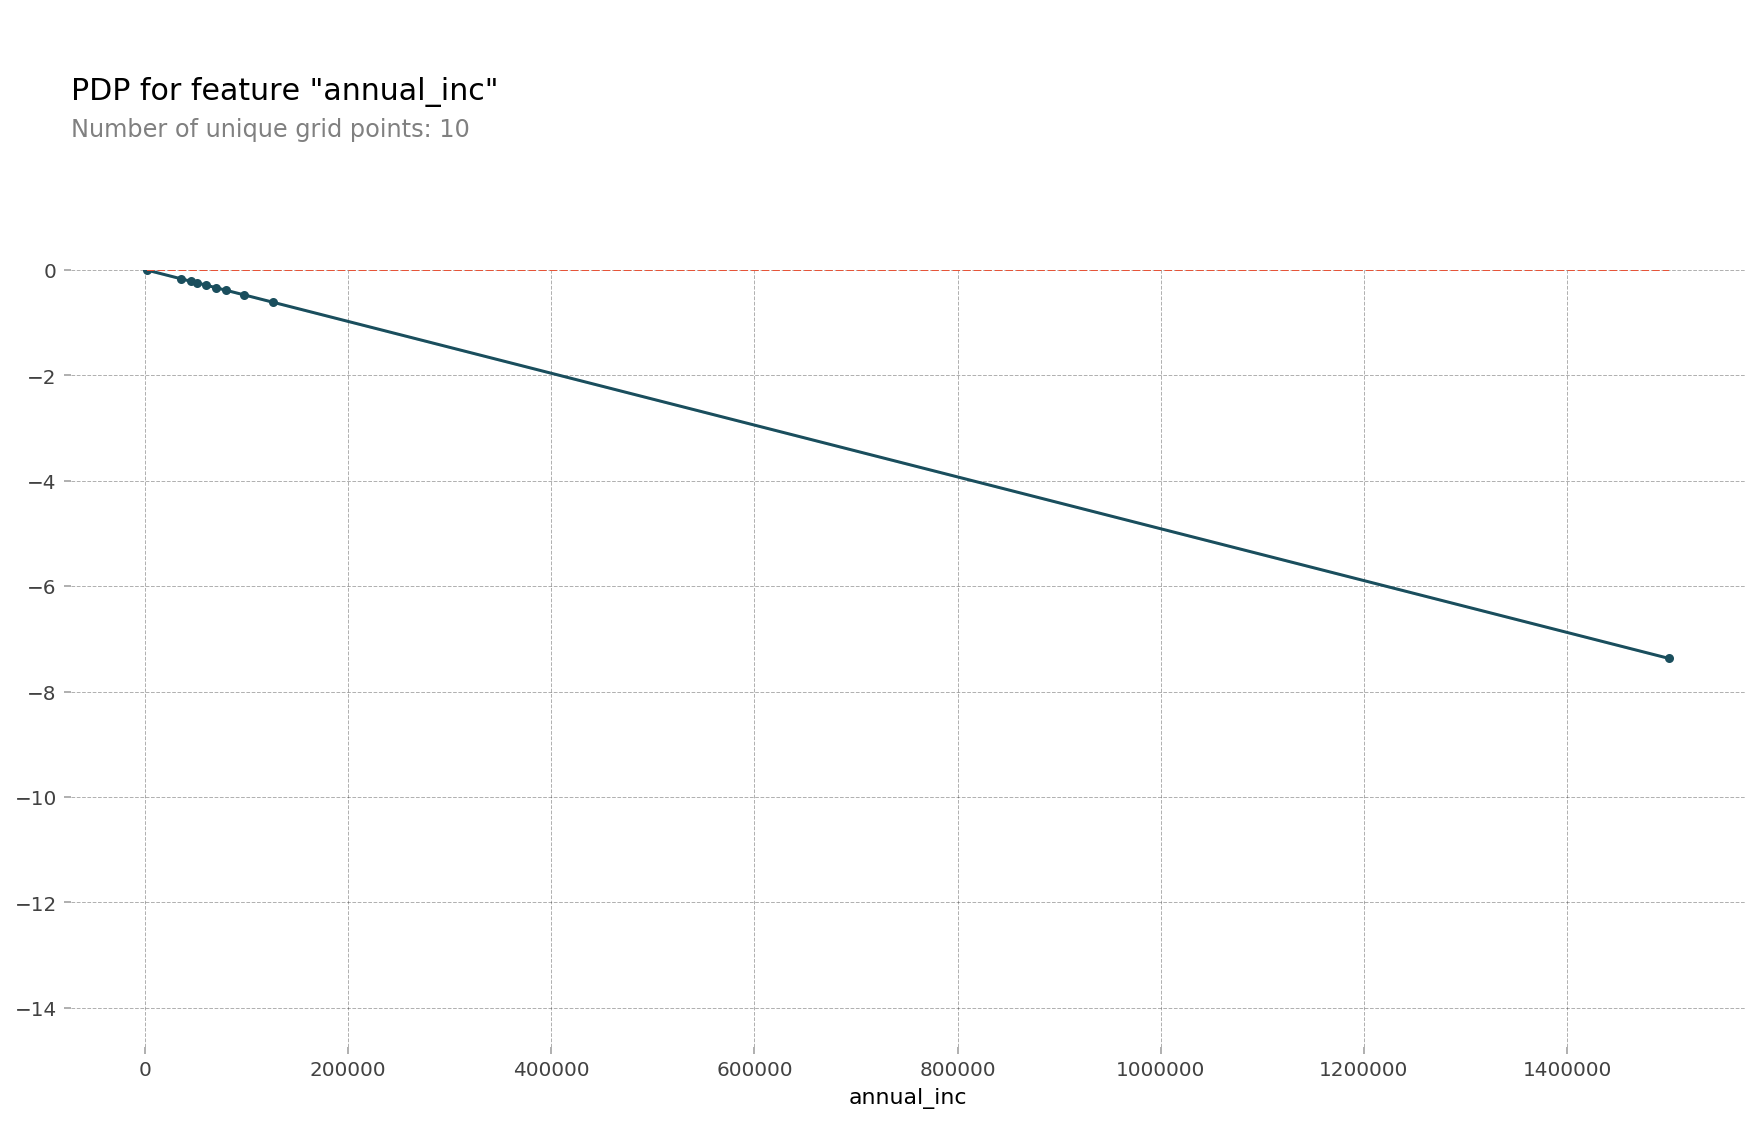

In [18]:
isolated = pdp_isolate(
    model=linear, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

#### 그래디언트 부스팅 모델에서 `annual_inc` PDP를 그려보겠습니다.

In [19]:
isolated = pdp_isolate(
    model=boosting, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

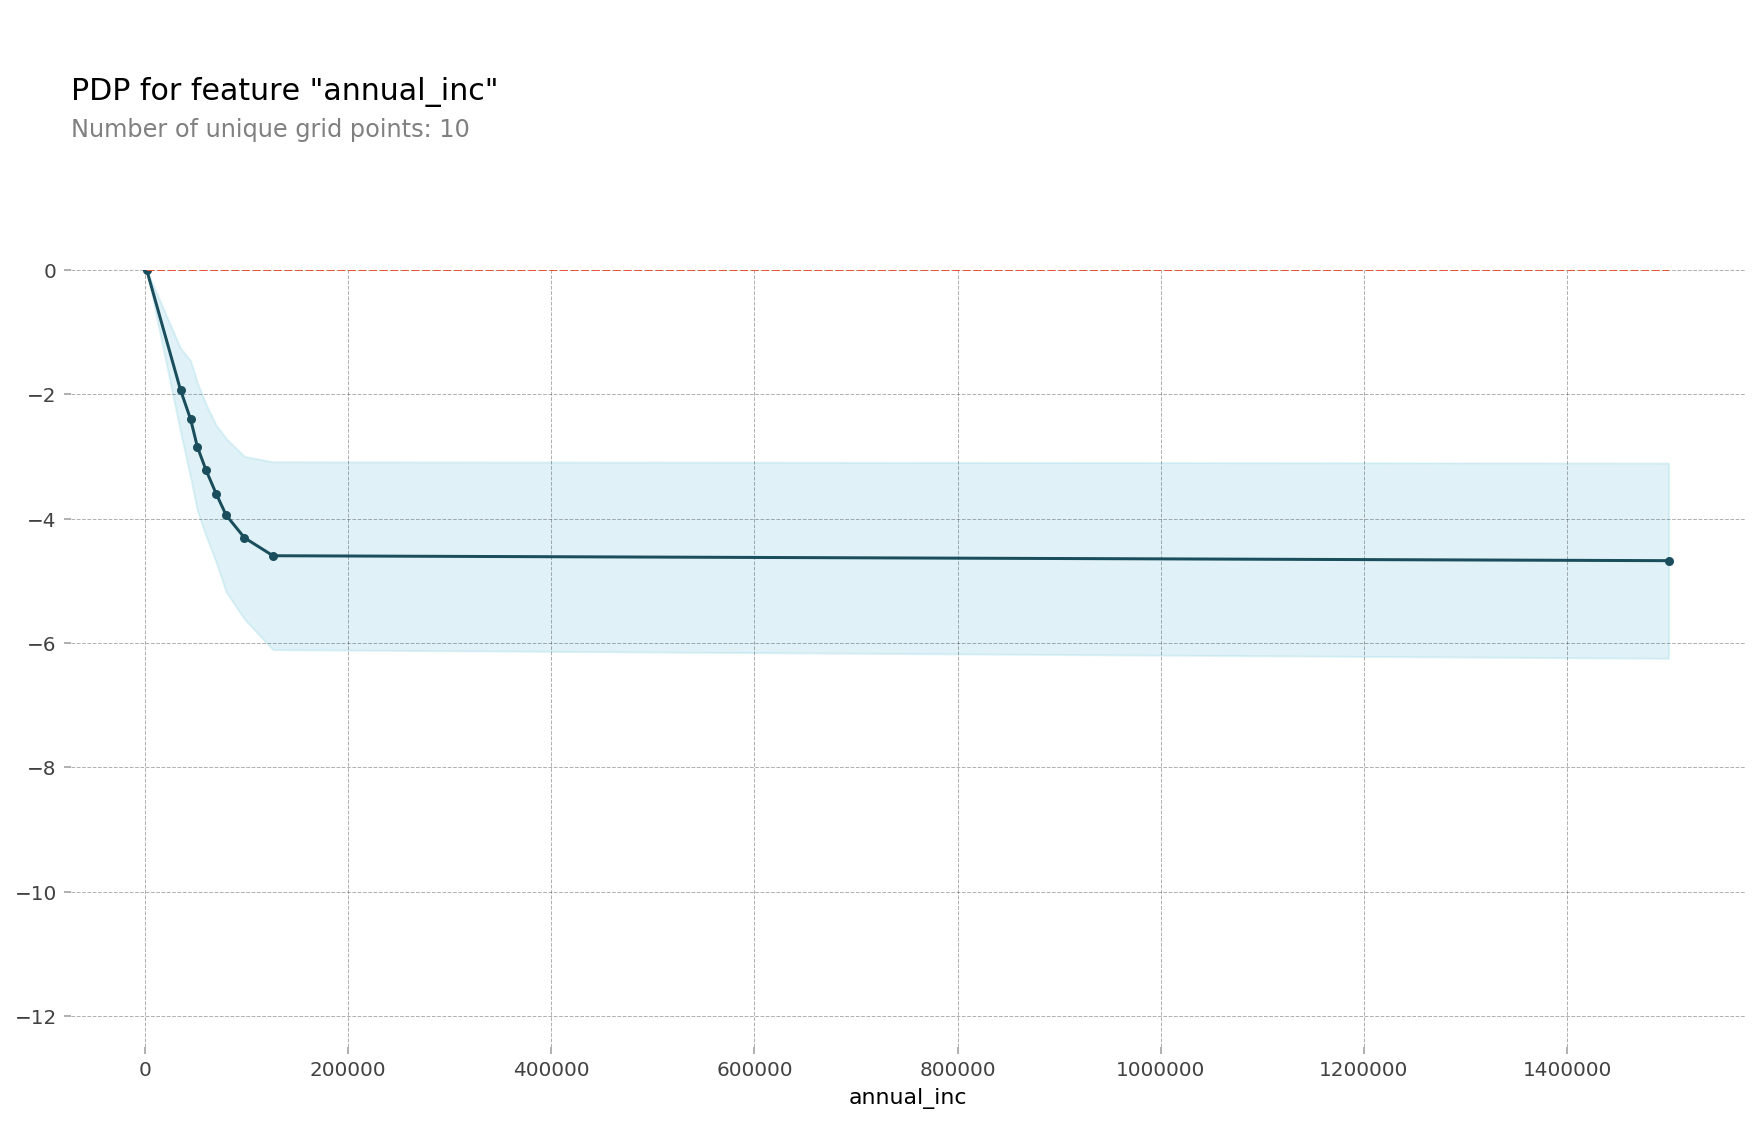

In [20]:
pdp_plot(isolated, feature_name=feature);

일부분을 확대하면

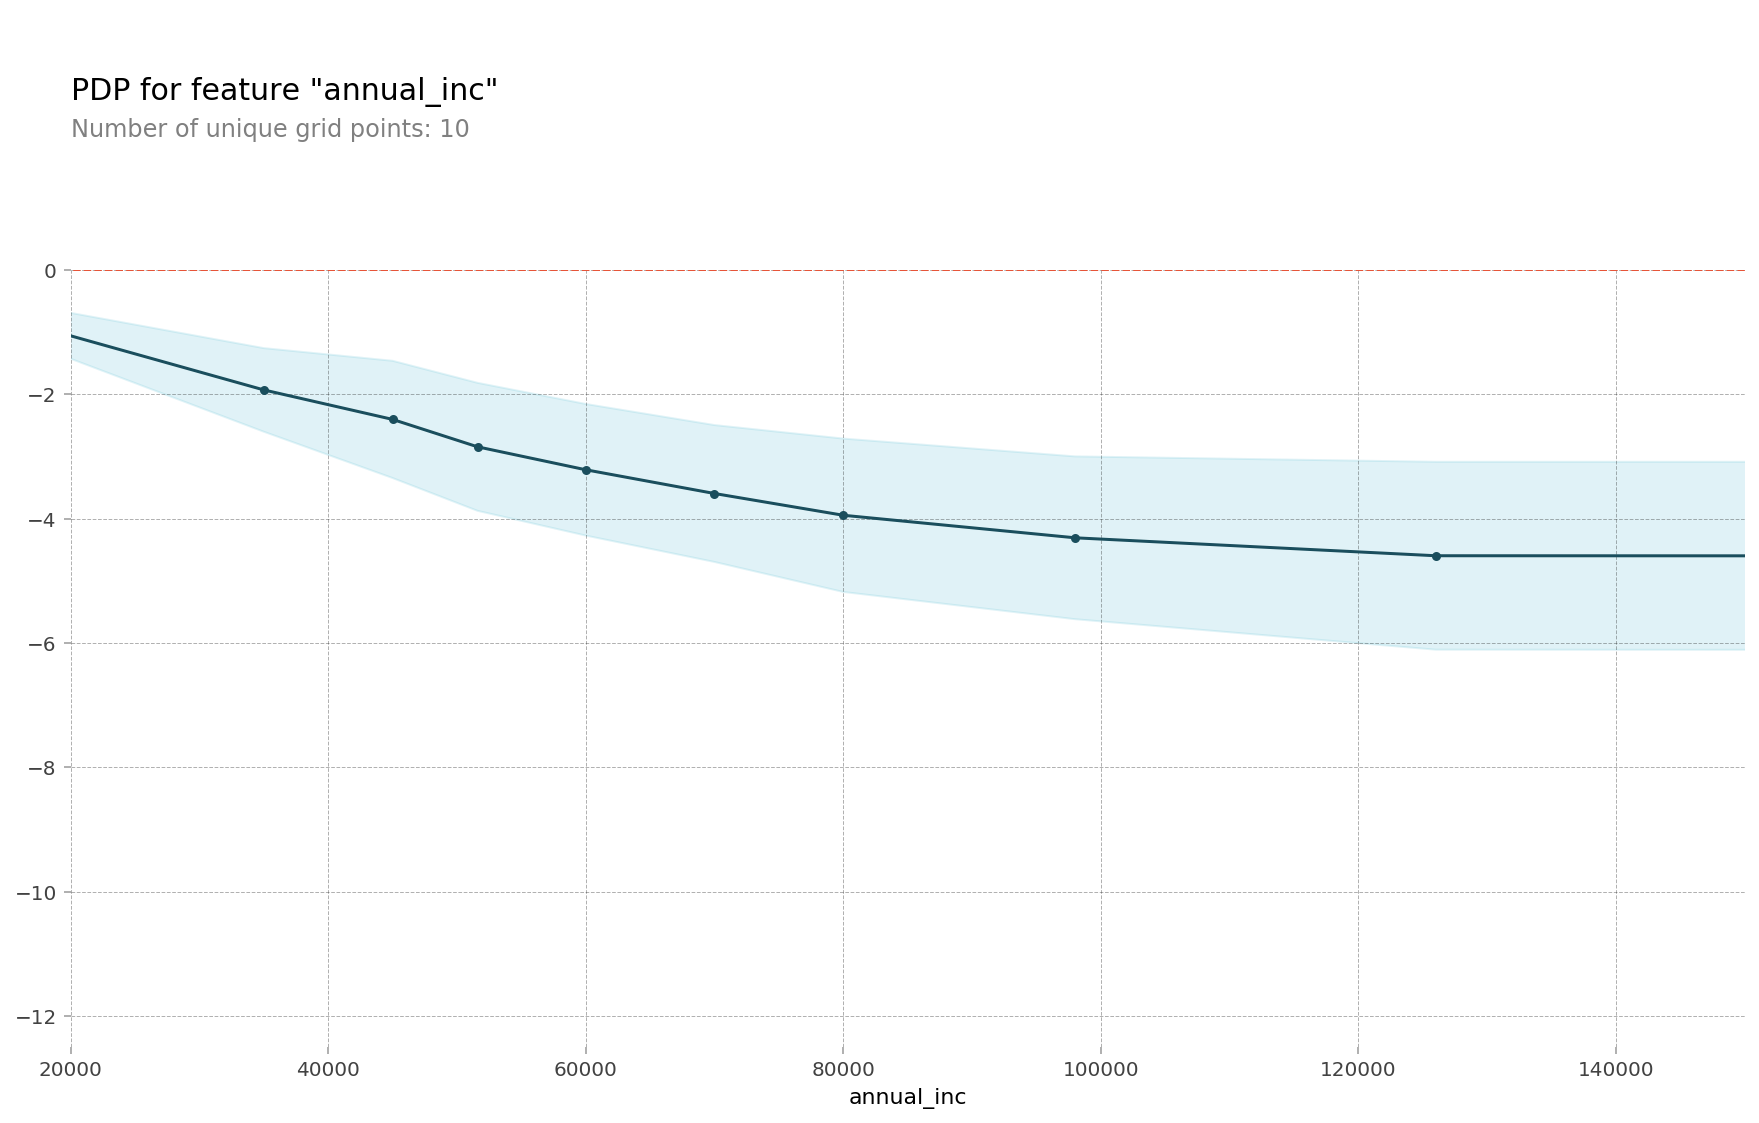

In [21]:
pdp_plot(isolated, feature_name=feature)
plt.xlim((20000,150000));

#### PDP 를 10개의 ICE(Individual Conditional Expectation) curves와 함께 그려보겠습니다.
한 ICE 곡선은 하나의 관측치에 대해 관심 특성을 변화시킴에 따른 타겟값 변화 곡선이고 이 ICE들의 평균이 PDP 입니다.

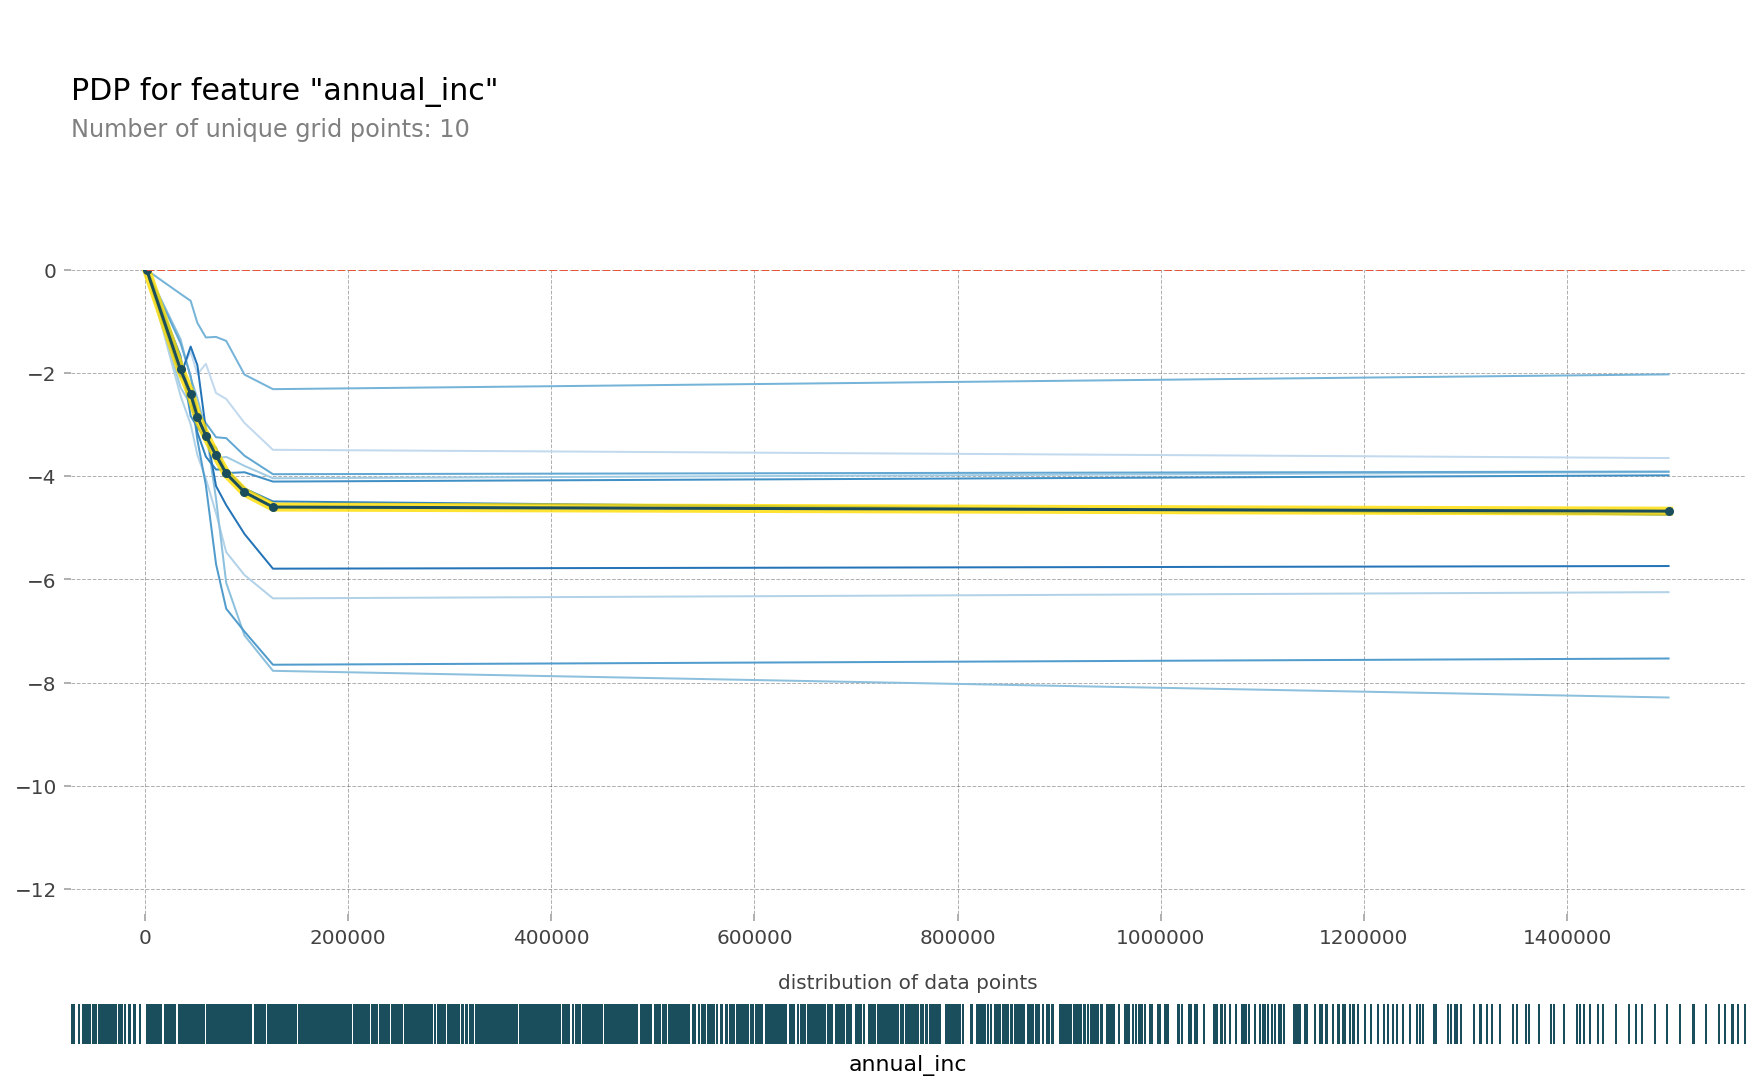

In [22]:
pdp_plot(isolated
         , feature_name=feature
         , plot_lines=True # ICE plots
         , frac_to_plot=0.001 # or 10 (# 10000 val set * 0.001)
         , plot_pts_dist=True) 

plt.xlim(20000,150000);

In [23]:
X_val_encoded['annual_inc'].value_counts()

60000.0    391
50000.0    388
65000.0    290
70000.0    282
40000.0    271
          ... 
16884.0      1
74400.0      1
36948.0      1
48281.0      1
50120.0      1
Name: annual_inc, Length: 1386, dtype: int64

#### ICE curves -> PDP 를 표현하는 GIF 입니다
[Christoph Molnar](https://twitter.com/ChristophMolnar/status/1066398522608635904)

##### 한 특성에 대해 PDP를 그릴 경우 얼마나 많은 예측이 필요할까요?
데이터셋 사이즈에 grid points를 곱한 수 만큼 예측을 해야 합니다.


In [24]:
isolated = pdp_isolate(
    model=boosting, 
    dataset=X_val_encoded, 
    model_features=X_val.columns, 
    feature=feature,
    # grid point를 크게 주면 겹치는 점이 생겨 Number of unique grid points는 grid point 보다 작을 수 있습니다.
    num_grid_points=100, # grid 포인트를 더 줄 수 있습니다. default = 10
)


In [25]:
print('예측수: ',len(X_val) * 100)

예측수:  1000000


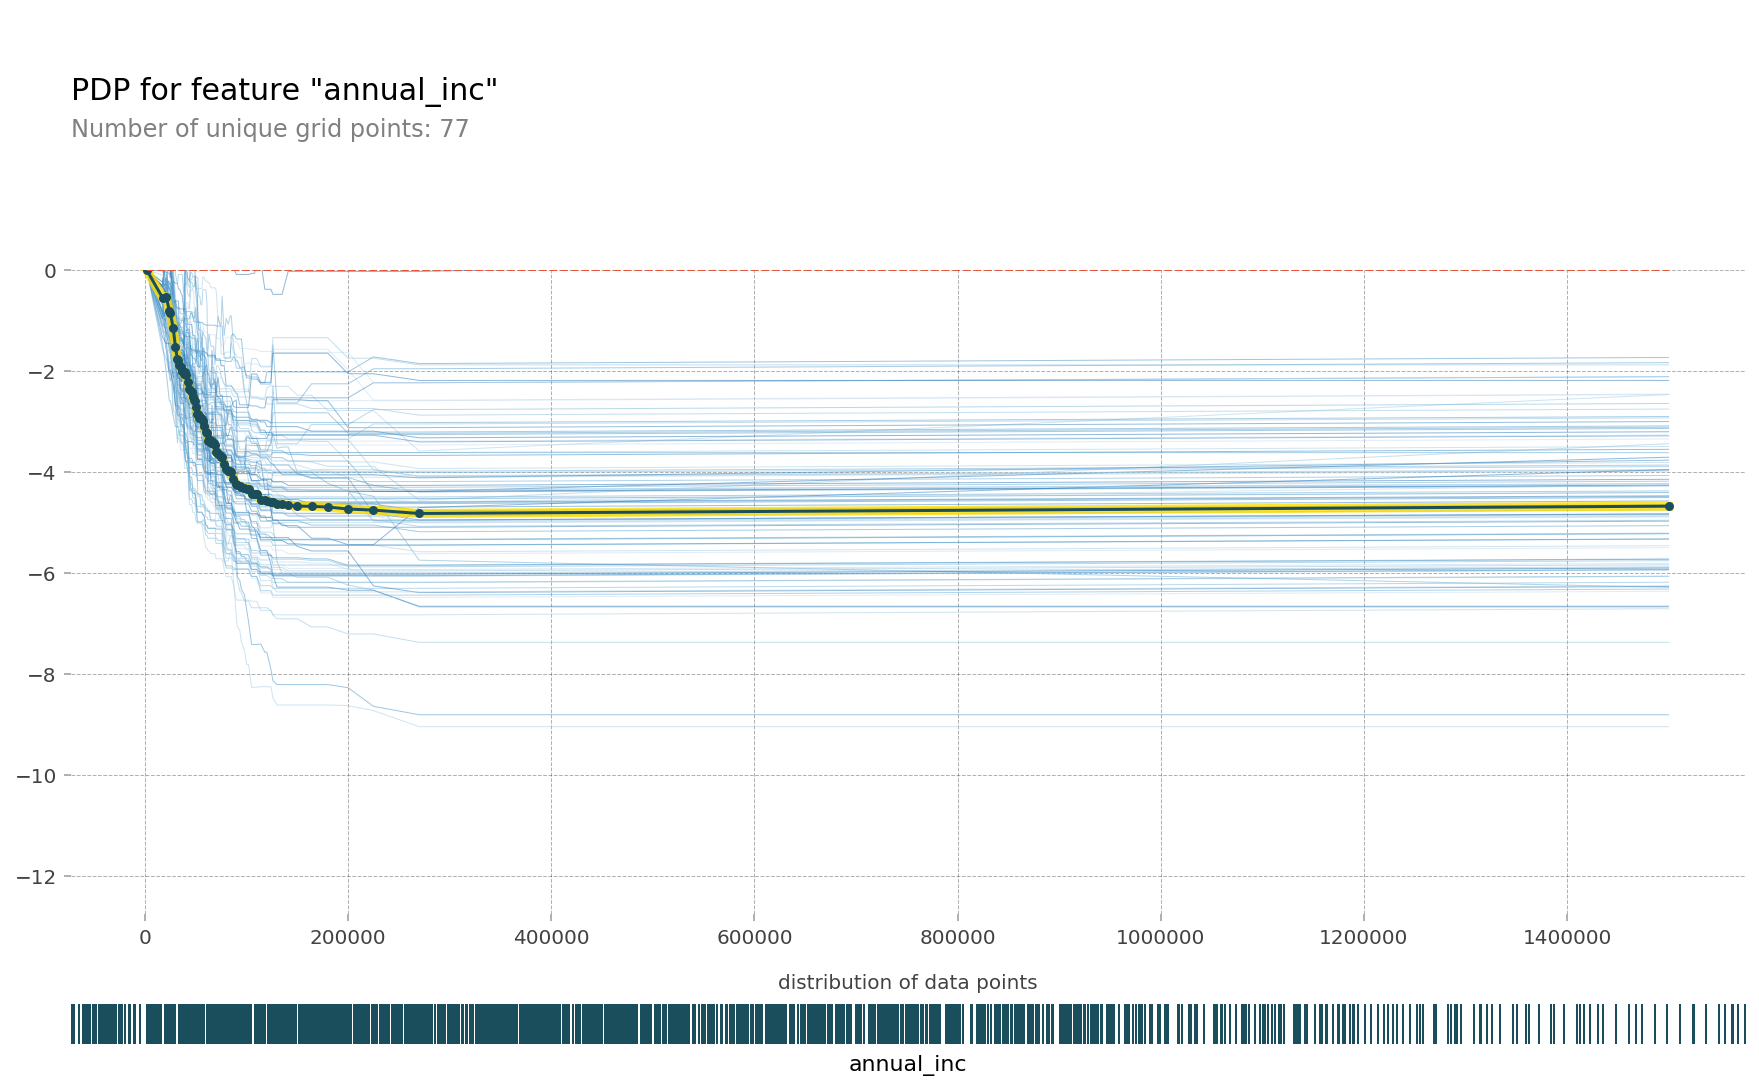

In [26]:
pdp_plot(isolated
         , feature_name=feature
         , plot_lines=True
         , frac_to_plot=0.01 # ICE curves는 100개
         , plot_pts_dist=True )

plt.xlim(20000,150000);

### PDP (2 특성 사용)

이번에는 **두 특성간의 상호작용**을 PDP를 통해 확인해 보겠습니다.

---
(참고: PDPBox version <= 0.20 과 몇몇 matplotlib 버전에서 `pdp_interact_plot`에서`plot_type='contour'` 설정시 에러가 발생할 수 있습니다.
`TypeError: clabel() got an unexpected keyword argument 'contour_label_fontsize'`
다음 링크를 확인해 주세요 https://github.com/SauceCat/PDPbox/issues/40)

---

In [27]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [28]:
features = ['annual_inc', 'fico_range_high']

interaction = pdp_interact(
    model=boosting, 
    dataset=X_val_encoded,
    model_features=X_val.columns, 
    features=features
)

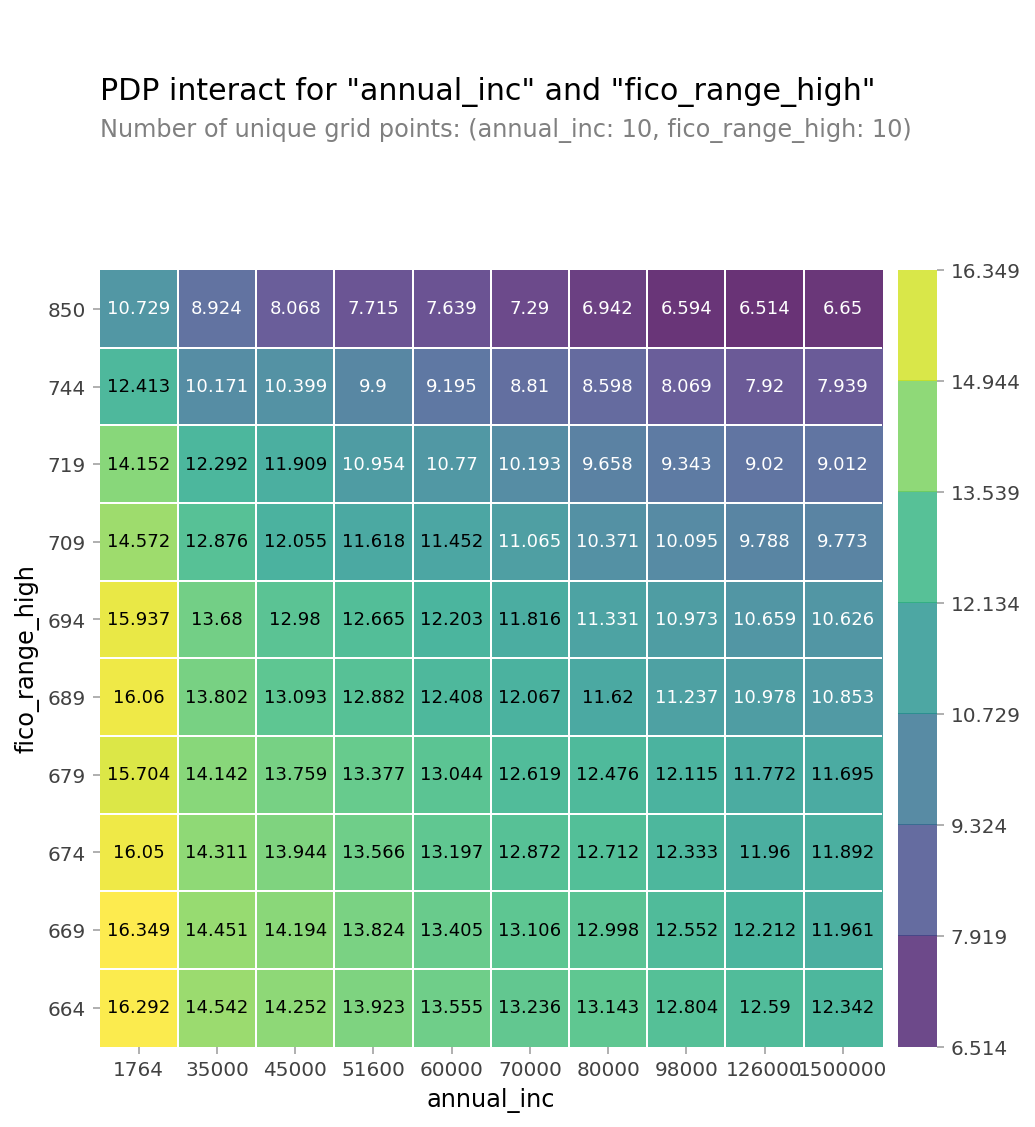

In [29]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

### PDP를 Plotly를 사용하여 3D로 보여줄 수 있습니다

In [30]:
features

['annual_inc', 'fico_range_high']

In [31]:
# 2D PDP dataframe
interaction.pdp

annual_inc  fico_range_high      preds
0       1764.0            664.0  16.292456
1       1764.0            669.0  16.348915
2       1764.0            674.0  16.049828
3       1764.0            679.0  15.703544
4       1764.0            689.0  16.059521
..         ...              ...        ...
95   1500000.0            694.0  10.625756
96   1500000.0            709.0   9.772980
97   1500000.0            719.0   9.012407
98   1500000.0            744.0   7.938867
99   1500000.0            850.0   6.650228

[100 rows x 3 columns]

In [32]:
type(interaction.pdp)

pandas.core.frame.DataFrame

In [33]:
# 위에서 만든 2D PDP를 테이블로 변환(using Pandas, df.pivot_table)하여 사용합니다

pdp = interaction.pdp.pivot_table(
    values='preds', # interaction['preds']
    columns=features[0], 
    index=features[1]
)[::-1] # 인덱스를 역순으로 만드는 slicing입니다

In [34]:
pdp

annual_inc       1764.0     35000.0    45000.0    51600.0    60000.0    \
fico_range_high                                                          
850.0            10.728621   8.923860   8.068137   7.714697   7.638650   
744.0            12.413086  10.170912  10.399019   9.899978   9.195316   
719.0            14.151695  12.292361  11.908611  10.954059  10.770252   
709.0            14.571562  12.876274  12.054502  11.617618  11.451913   
694.0            15.936883  13.680078  12.980091  12.665456  12.203492   
689.0            16.059521  13.801933  13.092834  12.882368  12.408401   
679.0            15.703544  14.141821  13.759470  13.377104  13.043536   
674.0            16.049828  14.311443  13.944260  13.566046  13.196841   
669.0            16.348915  14.450759  14.194402  13.823545  13.405274   
664.0            16.292456  14.542069  14.251584  13.923372  13.554600   

annual_inc       70000.0    80000.0    98000.0    126000.0   1500000.0  
fico_range_high                                                         
850.0             7.289989   6.942387   6.593600   6.513694   6.650228  
744.0             8.810282   8.597815   8.069159   7.920438   7.938867  
719.0            10.192616   9.657598   9.342922   9.020388   9.012407  
709.0            11.064891  10.370567  10.094723   9.787808   9.772980  
694.0            11.815606  11.331401  10.973445  10.659448  10.625756  
689.0            12.066990  11.619617  11.236561  10.978498  10.853028  
679.0            12.619294  12.476216  12.114724  11.772475  11.694901  
674.0            12.871801  12.712092  12.332758  11.960478  11.892471  
669.0            13.105941  12.997832  12.551519  12.212008  11.961063  
664.0            13.235728  13.142686  12.804372  12.590487  12.342085

In [35]:
# 양단에 극단적인 annual_inc를 drop 합니다
pdp = pdp.drop(columns=[1764.0, 1500000.0])

In [36]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

### PDP에서 카테고리특성을 사용

우리는 카테고리 특성을 학습할 때 Ordinal Encoder, Target Encoder 같은 인코더를 사용하게 됩니다. 인코딩을 하게되면 학습 후 PDP 를 그릴 때 인코딩된 값이 나오게 되어 카테고리특성의 실제 값을 확인하기 어려운 문제가 있습니다. 이번에는 PDP 에 인코딩되기 전 카테고리값을 보여주기 위한 방법을 알아 보겠습니다.

#### 이번 예시에서는 Titanic 데이터셋의 카테고리 특성을 사용해 보겠습니다

In [37]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

df = sns.load_dataset('titanic')
df['age'] = df['age'].fillna(df['age'].median())
df = df.drop(columns='deck') # NaN 77%
df = df.dropna()

target = 'survived'
features = df.columns.drop(['survived', 'alive'])

X = df[features]
y = df[target]

In [38]:
pipe = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipe.fit(X, y);

In [39]:
encoder = pipe.named_steps['ordinalencoder']
X_encoded = encoder.fit_transform(X)
rf = pipe.named_steps['randomforestclassifier']

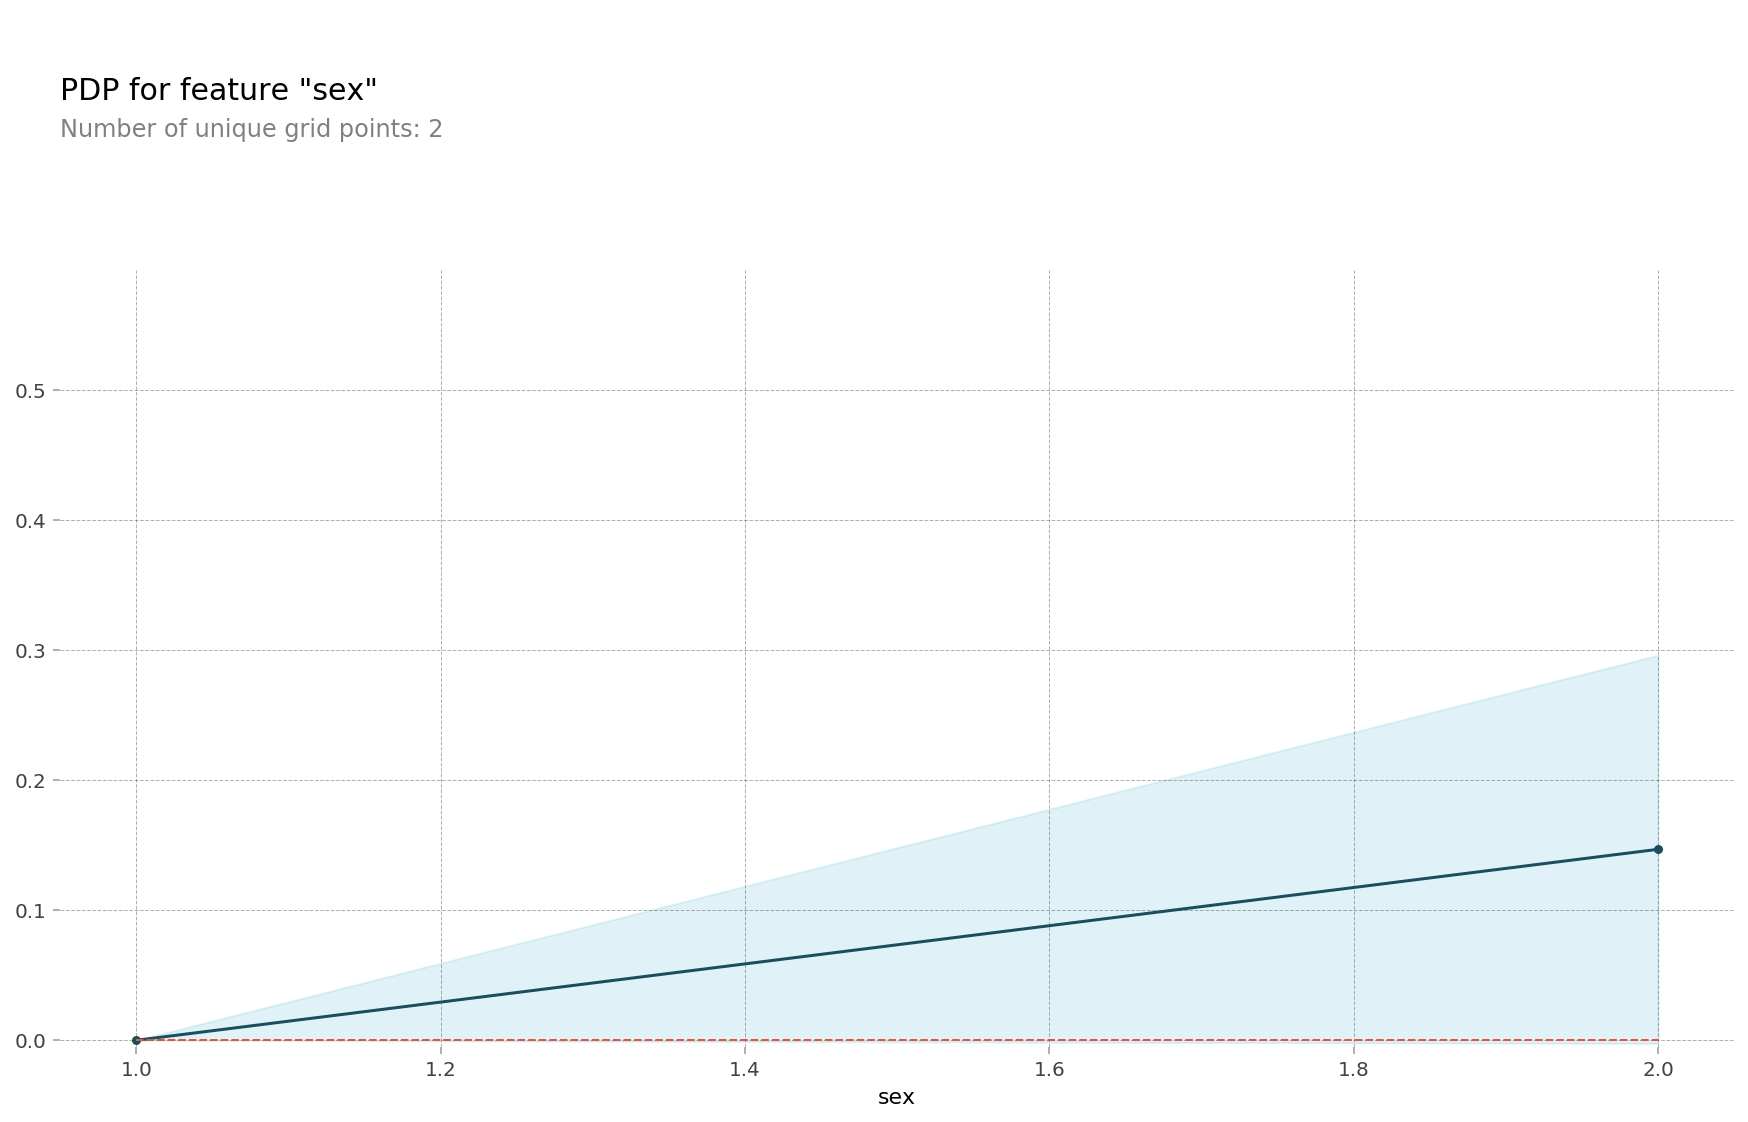

In [40]:
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'sex'
pdp_dist = pdp.pdp_isolate(model=rf, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature); # 인코딩된 sex 값을 확인할 수 있습니다

In [41]:
# encoder 맵핑을 확인합니다, {male:1, female:2} 로 인코딩 되어 있습니다
encoder.mapping

[{'col': 'sex', 'mapping': male      1
  female    2
  NaN      -2
  dtype: int64, 'data_type': dtype('O')},
 {'col': 'embarked', 'mapping': S      1
  C      2
  Q      3
  NaN   -2
  dtype: int64, 'data_type': dtype('O')},
 {'col': 'class', 'mapping': Third     1
  First     2
  Second    3
  NaN      -2
  dtype: int64, 'data_type': CategoricalDtype(categories=['First', 'Second', 'Third'], ordered=False)},
 {'col': 'who', 'mapping': man      1
  woman    2
  child    3
  NaN     -2
  dtype: int64, 'data_type': dtype('O')},
 {'col': 'embark_town', 'mapping': Southampton    1
  Cherbourg      2
  Queenstown     3
  NaN           -2
  dtype: int64, 'data_type': dtype('O')}]

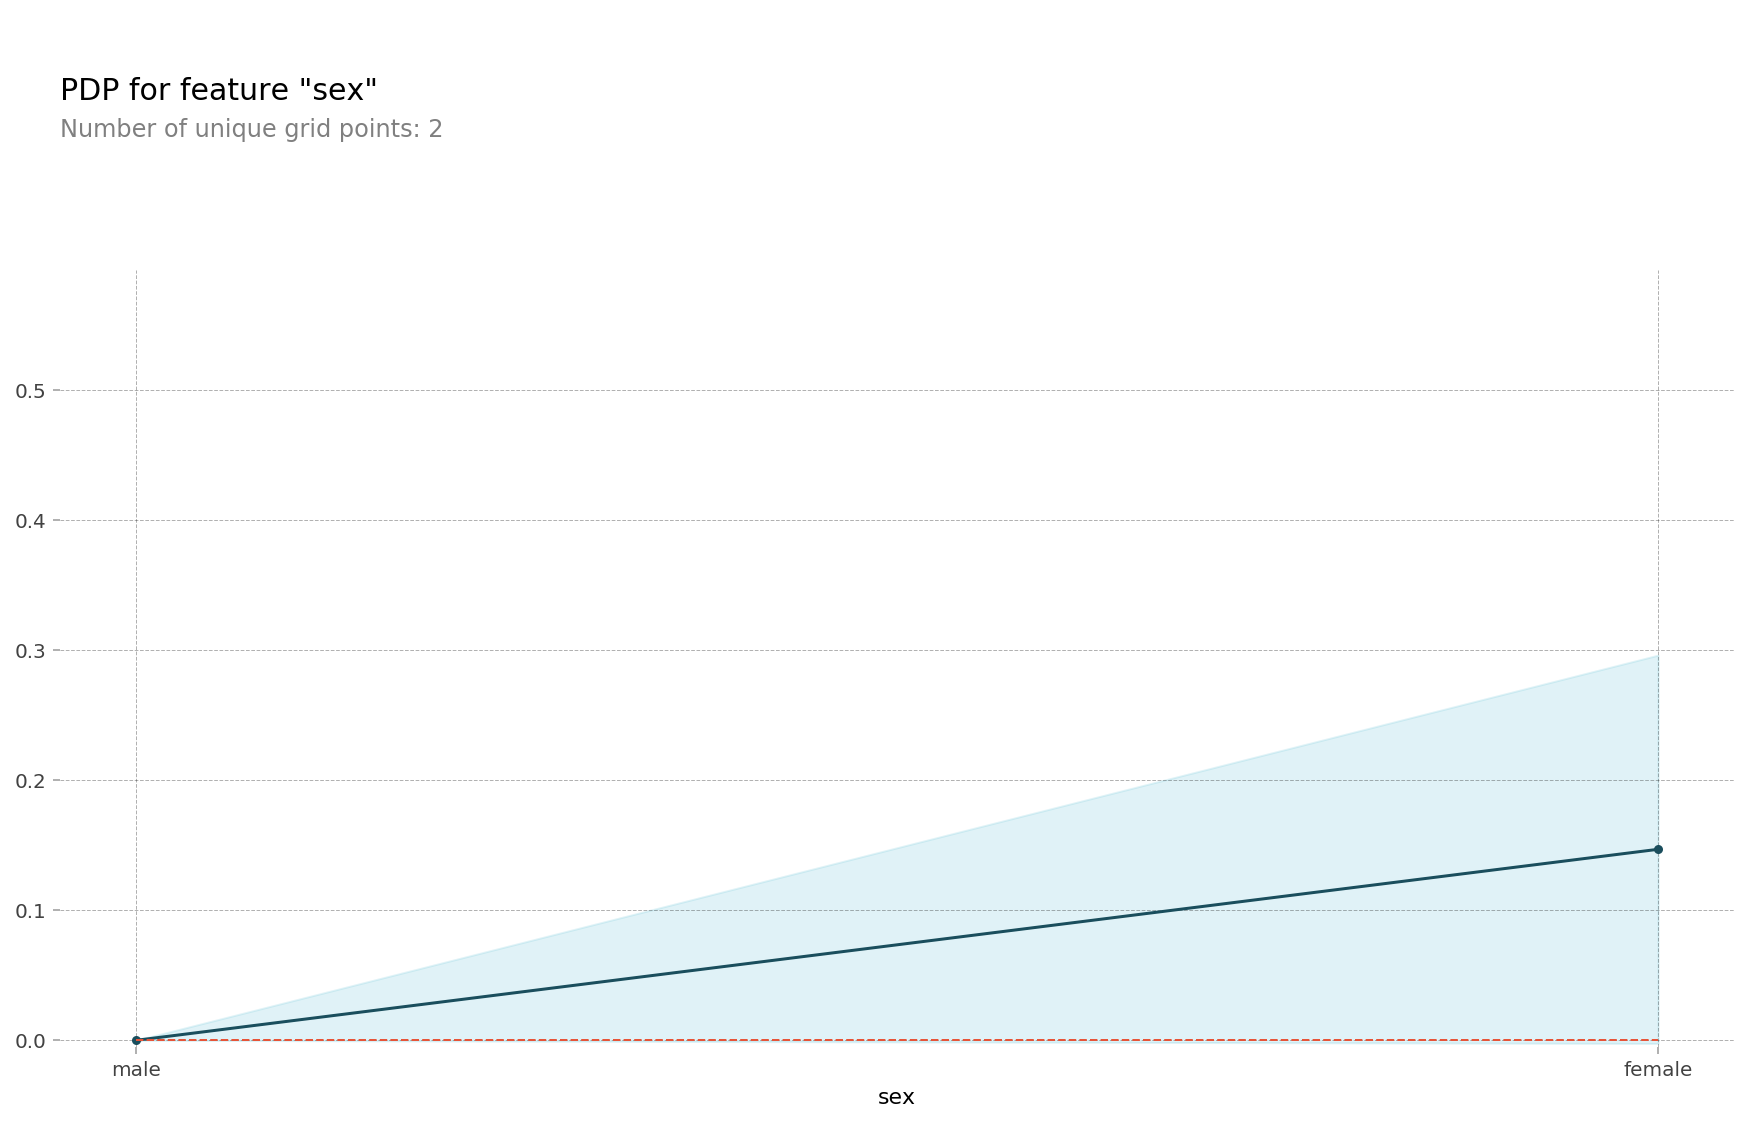

In [42]:
pdp.pdp_plot(pdp_dist, feature)

# xticks labels 설정을 인코딩된 코드리스트와, 카테고리 값 리스트를 넣어 수동으로 해보겠습니다.
plt.xticks([1, 2], ['male', 'female',]);

In [43]:
# 이번에는 PDP 카테고리값 맵핑을 자동으로 해보겠습니다

feature = 'sex'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

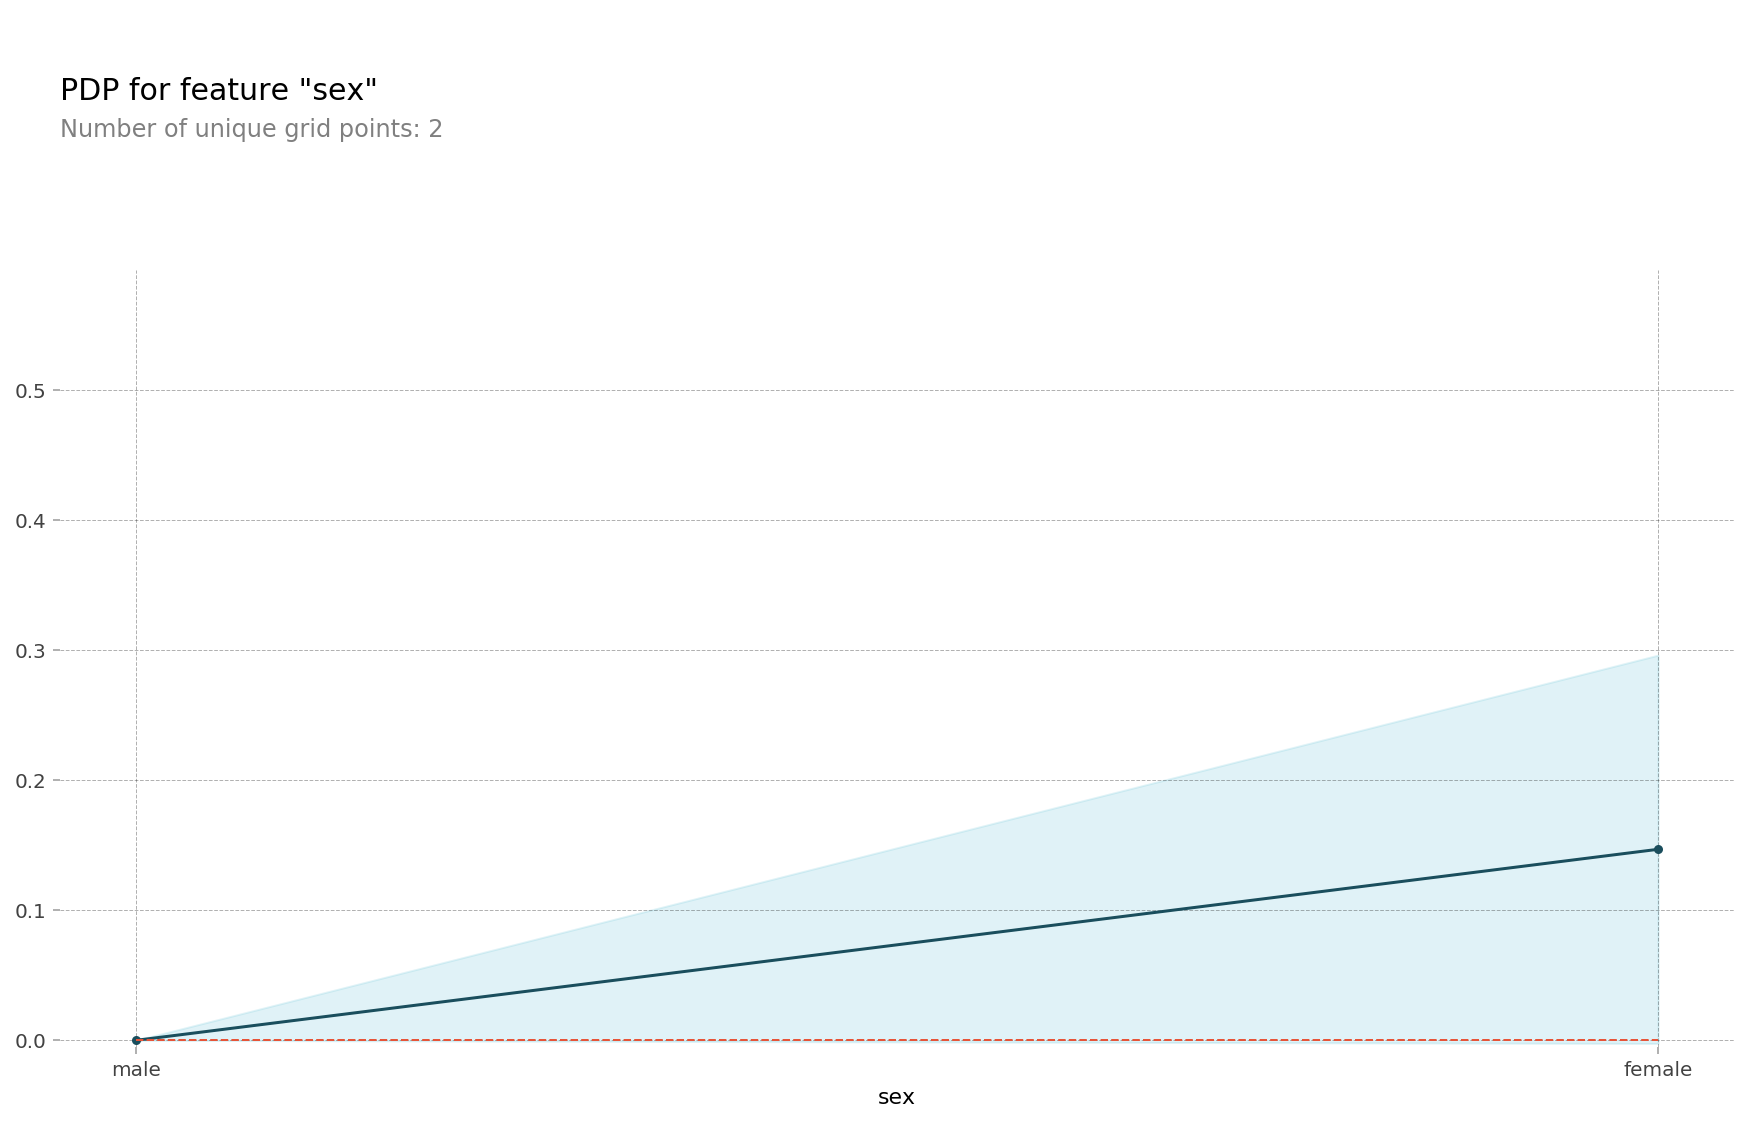

In [44]:
pdp.pdp_plot(pdp_dist, feature)

# xticks labels 설정을 위한 리스트를 직접 넣지 않아도 됩니다 
plt.xticks(category_codes, category_names);

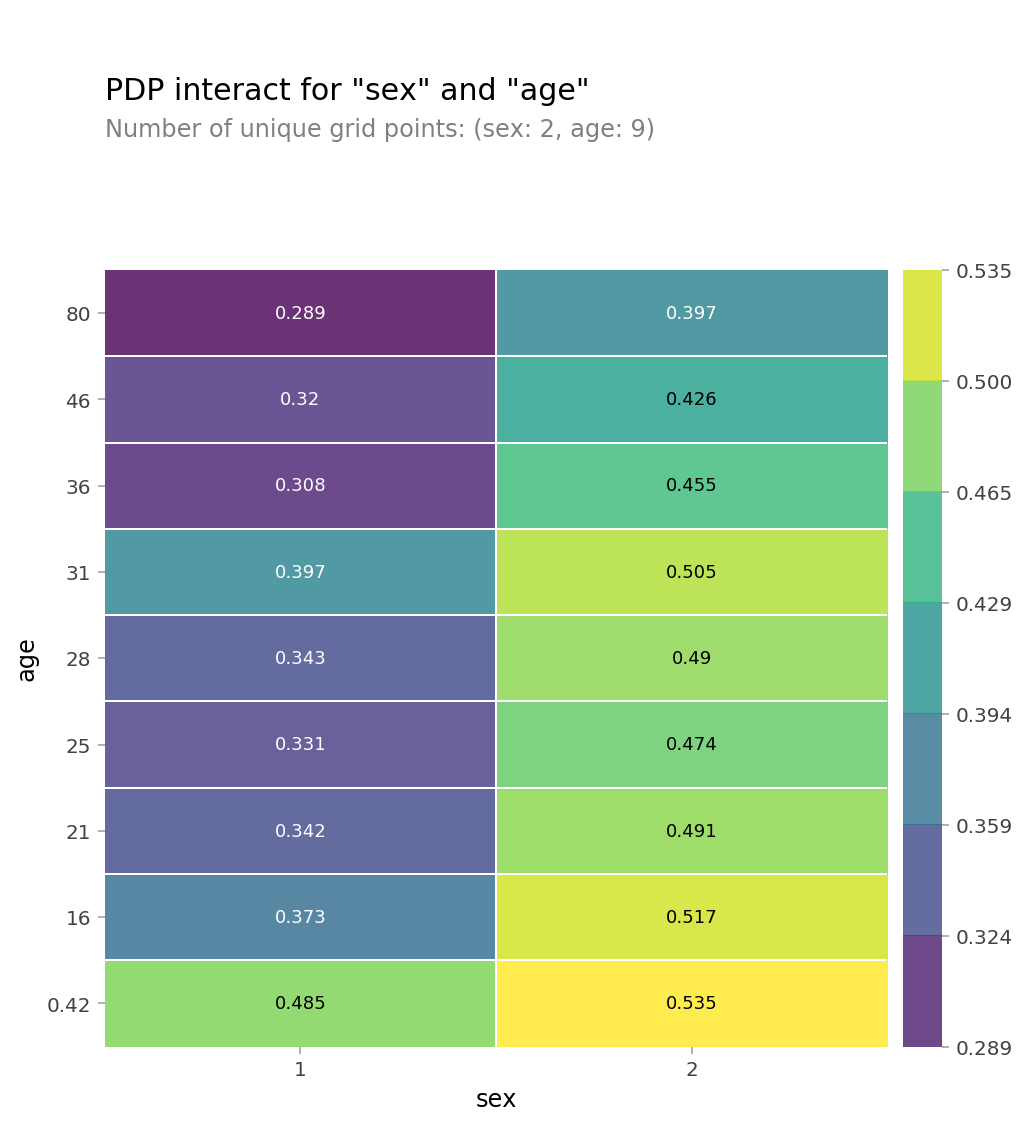

In [45]:
# 2D PDP
features = ['sex', 'age']

interaction = pdp_interact(
    model=rf, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

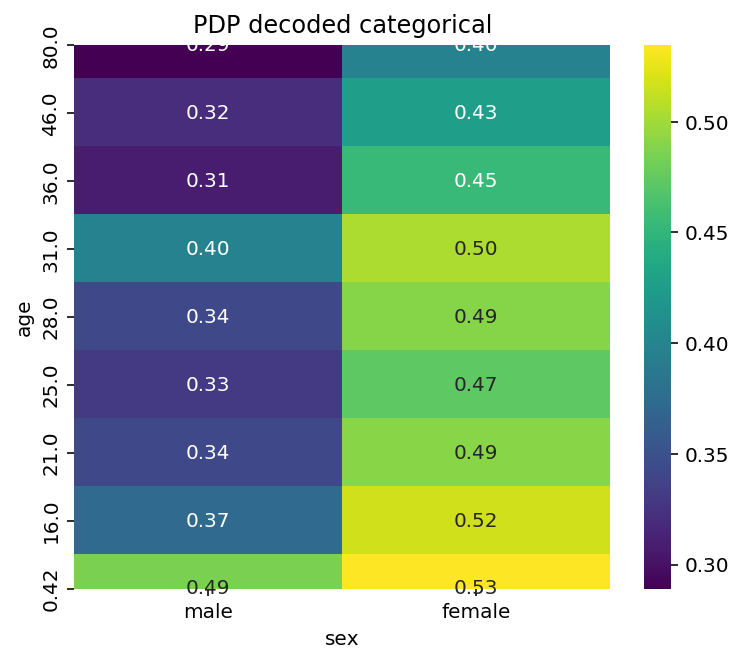

In [46]:
# 2D PDP 를 Seaborn Heatmap으로 그리기 위해 데이터프레임으로 만듭니다
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1]

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(6,5))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('PDP decoded categorical');

# SHAP 라이브러리를 이용해 개별 예측을 설명해 봅시다

어떤 머신러닝 모델이든지 단일 관측치로부터 특성들의 기여도(feature attribution)를 계산하기 위한 방법을 배워 보겠습니다.

Shapley value는 원래 게임이론에서 나온 개념이지만 복잡한 머신러닝모델의 예측을 설명하기 위한 매우 유용한 방법을 제공해 줍니다. 

<img src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_header.png" width="800" />

이제 [SHAP(SHapley Additive exPlanations)](https://github.com/slundberg/shap) 라이브러리를 이용해 Shapley values를 구하는 방법을 살펴보겠습니다.

### 회귀모델 예시를 사용해 진행하겠습니다.

In [47]:
import numpy as np
import pandas as pd

# 킹카운티 주택가격 데이터셋을 사용하겠습니다
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/kc_house_data/kc_house_data.csv')

# price, longitude, latitude 양 끝단 값 1% 제거합니다.
# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['long'] >= np.percentile(df['long'], 0.05)) & 
        (df['long'] <= np.percentile(df['long'], 99.95)) &
        (df['lat'] >= np.percentile(df['lat'], 0.05)) & 
        (df['lat'] < np.percentile(df['lat'], 99.95))]

# split train/test, 2015-03-01 기준으로 나눕니다
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
cutoff = pd.to_datetime('2015-03-01')
train = df[df['date'] < cutoff]
test  = df[df['date'] >= cutoff]

In [48]:
train.shape, test.shape

((16660, 21), (4691, 21))

In [49]:
train.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [50]:
features = ['bedrooms', 'bathrooms', 'long', 'lat']
target = 'price'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [51]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=2), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=2
)

search.fit(X_train, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [52]:
print('최적 하이퍼파라미터: ', search.best_params_)
print('CV MAE: ', -search.best_score_)
model = search.best_estimator_

최적 하이퍼파라미터:  {'max_depth': 15, 'max_features': 0.6327377306009369, 'n_estimators': 166}
CV MAE:  101224.42224844794


### Shapley values 

SHAP 라이브러리는 게임이론에 나오는 Shapley values 에 기초해 머신러닝에서 Shapley values를 계산할 수 있도록 합니다.

게임이론에서 같은 팀 선수들(특성들)이 게임 목표(예측) 달성을 위해 각자 자신의 역할(기여)을 한다고 할 때 게임 목표 달성 후 받은 포상을 어떻게 하면 그들의 기여도에 따라 공평하게 나누어 줄 수 있을 것인가? 라는 질문과 연관됩니다.

이 Shapley value를 머신러닝의 특성 기여도(feature attribution) 산정에 활용한다는 것은 다음과 같습니다.

<img src="https://i.imgur.com/3f8NVD4.png" />

사실 특성 갯수가 많아질 수록 Shapley value를 구할 때 필요한 계산량이 기하급수적으로 늘어납니다. 그래서 SHAP에서는 샘플링을 이용해 근사적으로 값을 구합니다. 앞으로 SHAP을 통해 구하는 값은 Shap value라고 부르겠습니다.


#### 예시로 테스트세트에서 두 번째 샘플의 Shap value를 구해보겠습니다.

In [53]:
row = X_test.iloc[[1]]  # 중첩 brackets을 사용하면 결과물이 DataFrame입니다
row

bedrooms  bathrooms     long      lat
9         3        2.5 -122.031  47.3684

In [54]:
# 실제 집값
y_test.iloc[[1]] # 2번째 데이터를 사용했습니다


9    323000.0
Name: price, dtype: float64

In [55]:
# 모델 예측값
model.predict(row)


array([341878.50142523])

In [56]:
# 모델이 이렇게 예측한 이유를 알기 위하여
# SHAP Force Plot을 그려보겠습니다.

import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [57]:
# 집 가격 평균값을 base value로 합니다.
explainer.expected_value[0]

525264.9249674568

이 관측치의 예측값이 왜 341,878.50 이 나오게 되었는지 각 특성(bathrooms, lat, bedrooms)의 영향을 시각화 하였습니다.

#### 예측함수를 정의합니다.

In [58]:
def predict(bedrooms, bathrooms, longitude, latitude):

    # 함수 내에서 예측에 사용될 input을 만듭니다
    df = pd.DataFrame(
        data=[[bedrooms, bathrooms, longitude, latitude]], 
        columns=['bedrooms', 'bathrooms', 'long', 'lat']
    )

    # 예측
    pred = model.predict(df)[0]

    # Shap value를 계산합니다
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df)

    # Shap value, 특성이름, 특성값을 가지는 Series를 만듭니다
    feature_names = df.columns
    feature_values = df.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

    # 결과를 프린트 합니다.
    result = f'평균가격: ${explainer.expected_value[0]:,.0f} \n'
    result += f'예측가격: ${pred:,.0f}. \n'
    result += shaps.to_string()
    print(result)


    # SHAP Force Plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=df
    )

적당한 지역을 관측치로 사용하기 위해 lat의 분포를 보겠습니다.

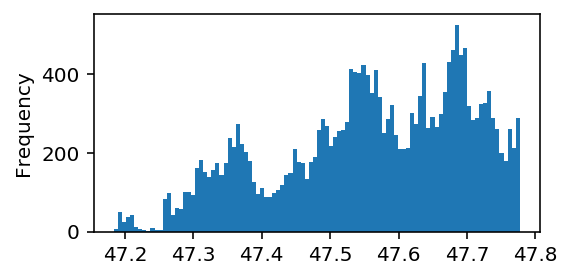

In [59]:
df['lat'].plot.hist(bins=100, figsize=(4, 2));

#### 적당한 지역에 방 3개 집 가격을 예측해 봅시다.

In [60]:
predict(3, 1, -121.35, 47.55)

평균가격: $525,265 
예측가격: $382,123. 
(bedrooms, 3.0)     -25124.723574
(bathrooms, 1.0)   -142083.969321
(long, -121.35)     -21022.116137
(lat, 47.55)         45088.940133


#### 같은 지역에 방 2개 집 가격을 예측해 보면, 지역(lat) 수치가 같음에도 영향은 달라짐을 확인할 수 있습니다.

In [61]:
predict(2, 1, -122.35, 47.55)

평균가격: $525,265 
예측가격: $281,714. 
(bedrooms, 2.0)     -45592.182391
(bathrooms, 1.0)   -118088.150603
(long, -122.35)     -62003.221763
(lat, 47.55)        -17867.074728


#### 같은 지역에 방 1개 집 가격을 예측해 보면

In [62]:
predict(1, 1, -122.35, 47.55)

평균가격: $525,265 
예측가격: $277,940. 
(bedrooms, 1.0)     -54303.671169
(bathrooms, 1.0)   -120596.652648
(long, -122.35)     -60103.932089
(lat, 47.55)        -12320.268028


#### 여러가지 SHAP plot으로 각 특성이 어떤 값 범위에서 어떤 영향을 주는지 확인할 수 있습니다

In [63]:
# 100개 테스트 샘플에 대해서 각 특성들의 영향을 봅니다. 샘플 수를 너무 크게 잢으면 계산이 오래걸리니 주의하세요.
shap_values = explainer.shap_values(X_test.iloc[:100])
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[:100])


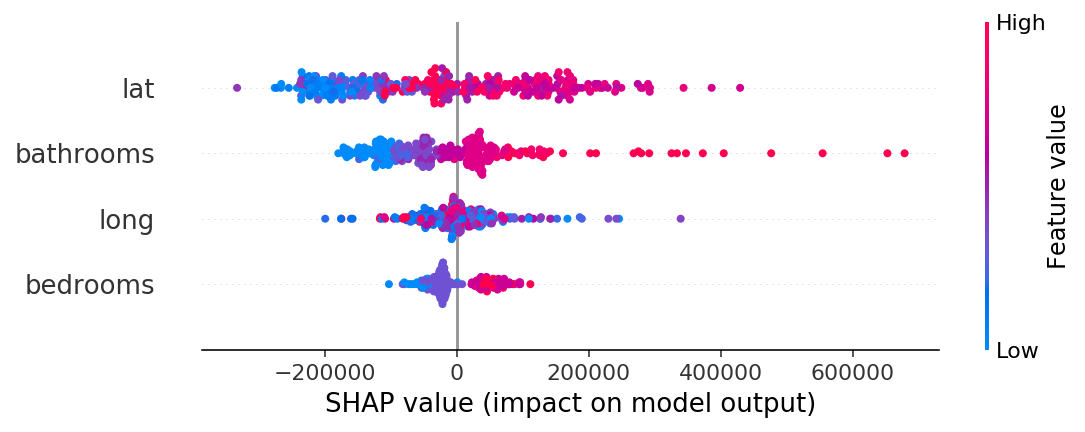

In [64]:
shap_values = explainer.shap_values(X_test.iloc[:300])
shap.summary_plot(shap_values, X_test.iloc[:300])

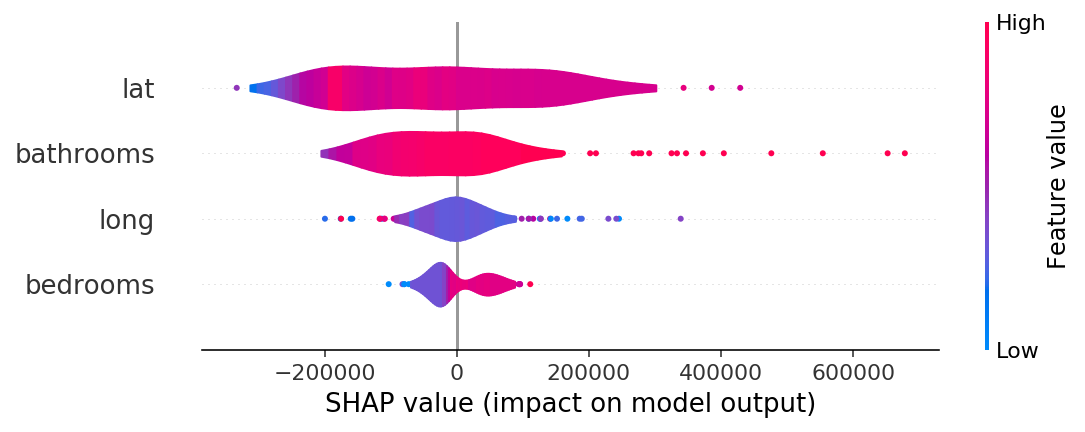

In [65]:
shap.summary_plot(shap_values, X_test.iloc[:300], plot_type="violin")

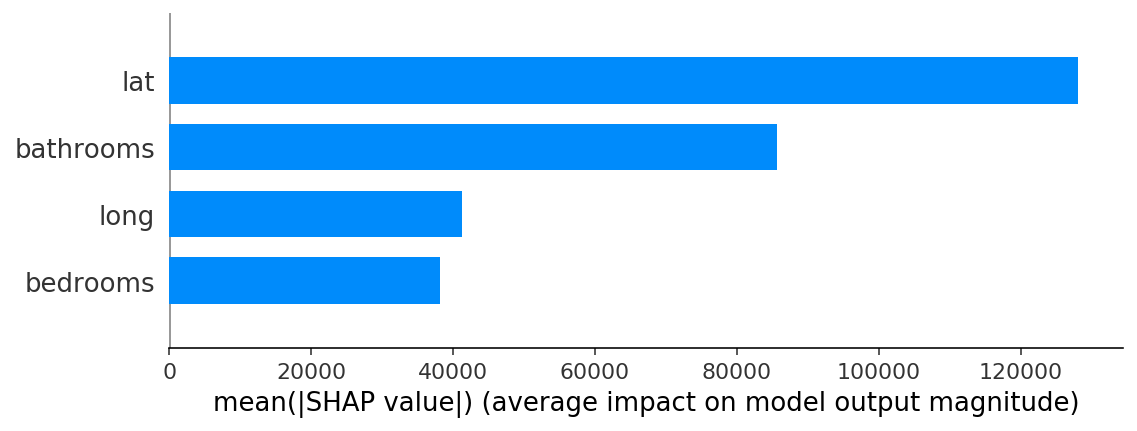

In [66]:
shap.summary_plot(shap_values, X_test.iloc[:300], plot_type="bar")

### SHAP value를 분류 문제에 적용해 봅시다

이번에는 분류문제를 풀기 위해 Lending Club 데이터를 사용하겠습니다. 대출 상태가 'charged off'(상각) 인지 'fully paid'(완납) 인지 예측하는 문제 입니다.


In [67]:
import pandas as pd

# Kaggle 데이터셋에서 10% 샘플링된 데이터입니다.
## Source: https://www.kaggle.com/wordsforthewise/lending-club
## 10% of expired loans (loan_status: ['Fully Paid' and 'Charged Off'])
## grades A-D
## term ' 36 months'
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/lending_club/lending_club_sampled.csv', index_col=0)

In [68]:
# 2-class 타겟 ('Fully Paid' or 'Charged Off')
target = 'loan_status'
X = df.drop(columns=target)
y = df[target]

In [69]:
# 데이터셋 분리
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=10000
    , stratify=y
    , random_state=2)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000
    , stratify=y_train_val
    , random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (77591, 150)
y_train shape (77591,)
X_val shape (10000, 150)
y_val shape (10000,)
X_test shape (10000, 150)
y_test shape (10000,)


In [70]:
# test ids를 저장하고 SHAP분석시 사용합니다
test_id = X_test['id']

In [71]:
def wrangle(X):
    X = X.copy()

    # to datetime
    X['issue_d'] = pd.to_datetime(X['issue_d'], infer_datetime_format=True)
    
    # 개설 날짜 - 최초 신용 개설
    X['earliest_cr_line'] = pd.to_datetime(X['earliest_cr_line'], infer_datetime_format=True)
    X['earliest_cr_line'] = X['issue_d'] - X['earliest_cr_line']
    X['earliest_cr_line'] = X['earliest_cr_line'].dt.days

    # Engineer issue_d_year
    X['issue_d_year'] = X['issue_d'].dt.year
    
    # Engineer issue_d_year
    X['issue_d_month'] = X['issue_d'].dt.month
            
    # non-digit 문자 치환 -> '', float변환
    X['emp_length'] = X['emp_length'].str.replace(r'\D','').astype(float)
        
    # Get length of free text fields
    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()
    
    # sub_grade 숫자 치환
    sub_grade_ranks = {'A1': 1.1, 'A2': 1.2, 'A3': 1.3, 'A4': 1.4, 'A5': 1.5, 
                       'B1': 2.1, 'B2': 2.2, 'B3': 2.3, 'B4': 2.4, 'B5': 2.5, 
                       'C1': 3.1, 'C2': 3.2, 'C3': 3.3, 'C4': 3.4, 'C5': 3.5, 
                       'D1': 4.1, 'D2': 4.2, 'D3': 4.3, 'D4': 4.4, 'D5': 4.5}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)
    
    # 크게 의미 없는 특성 삭제
    X = X.drop(columns='id')        # Always unique
    X = X.drop(columns='url')       # Always unique
    X = X.drop(columns='grade')     # Duplicative of sub_grade
    X = X.drop(columns='zip_code')  # High cardinality
    X = X.drop(columns='issue_d')   # date
    
    # drop null > 70%
    null_frac = X.isnull().mean().sort_values(ascending=False)
    X = X.drop(columns = sorted(list(null_frac[null_frac > 0.7].index)))
    
    # Keep list (https://www.kaggle.com/pileatedperch/predicting-charge-off-from-initial-listing-data)
    # 잠재적인 투자자에게만 제공되는 특성으로만 제한합니다
    keep_list = keep_list = [
        'addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length'
        , 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id'
        , 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status'
        , 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal'
        , 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']
    drop_list = [col for col in X.columns if col not in keep_list]
    X = X.drop(labels=drop_list, axis=1)
        
    # Reset index
    X = X.reset_index(drop=True)
    
    return X

X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)

print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)

X_train shape (77591, 26)
X_val shape (10000, 26)
X_test shape (10000, 26)


In [72]:
# 클래스의 비율
y_train.value_counts(normalize=True)

Fully Paid     0.847328
Charged Off    0.152672
Name: loan_status, dtype: float64

In [73]:
ratio = 0.15/0.84
ratio

0.17857142857142858

## XGBoost 모듈의 업데이트로 target y 의 레이블링을 0, 1으로 따로 해줘야 하게 바뀌었다

In [80]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)

In [81]:
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

# XGBoost 분류기를 학습시킵니다. 클래스 비율을 맞추기 위해 scale_pos_weight= #Charged Off / # Fully Paid
model = XGBClassifier(n_estimators=1000, verbosity=0, n_jobs=-1, scale_pos_weight=ratio)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.68092	validation_1-auc:0.66370
[1]	validation_0-auc:0.68988	validation_1-auc:0.67363
[2]	validation_0-auc:0.69617	validation_1-auc:0.67690
[3]	validation_0-auc:0.70074	validation_1-auc:0.67876
[4]	validation_0-auc:0.70499	validation_1-auc:0.68039
[5]	validation_0-auc:0.70817	validation_1-auc:0.68202
[6]	validation_0-auc:0.71157	validation_1-auc:0.68287
[7]	validation_0-auc:0.71452	validation_1-auc:0.68418
[8]	validation_0-auc:0.71853	validation_1-auc:0.68446
[9]	validation_0-auc:0.72202	validation_1-auc:0.68474
[10]	validation_0-auc:0.72456	validation_1-auc:0.68577
[11]	validation_0-auc:0.72757	validation_1-auc:0.68632
[12]	validation_0-auc:0.73105	validation_1-auc:0.68667
[13]	validation_0-auc:0.73271	validation_1-auc:0.68708
[14]	validation_0-auc:0.73453	validation_1-auc:0.68692
[15]	validation_0-auc:0.73604	validation_1-auc:0.68680
[16]	validation_0-auc:0.73688	validation_1-auc:0.68657
[17]	validation_0-auc:0.73855	validation_1-auc:0.68674
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [82]:
model.classes_

array([0, 1])

In [83]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
X_val_processed = processor.transform(X_val)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test AUC for class "{model.classes_[class_index]}":')
print(roc_auc_score(y_test, y_pred_proba)) # 범위는 0-1, 수치는 높을 수록 좋습니다

Test AUC for class "1":
0.6839267781606986


In [84]:
# Confution matrix를 확인해 봅시다
from sklearn.metrics import classification_report
y_test_pred = model.predict(X_test_processed)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.24      0.66      0.35      1527
           1       0.91      0.61      0.73      8473

    accuracy                           0.62     10000
   macro avg       0.57      0.64      0.54     10000
weighted avg       0.81      0.62      0.67     10000



#### 예측값 vs 실제값을 비교해 보겠습니다.

In [85]:
df_p = pd.DataFrame({
    'id': test_id, 
    'pred_proba': y_pred_proba, # 예측확률 
    'status_group': y_test # 실제값
})

df_p = df_p.merge(
     df[['id','issue_d','sub_grade','total_pymnt','funded_amnt', 'term','int_rate']],
     how='left'
)

In [86]:
df_p.head()

id  pred_proba  status_group   issue_d sub_grade   total_pymnt  \
0   57714128    0.678374             1  Aug-2015        B1  22351.903560   
1   89784537    0.497685             0  Sep-2016        C1   7047.420000   
2  127937389    0.826874             1  Jan-2018        A3  20462.631376   
3   15169129    0.660449             1  May-2014        B4  13832.530000   
4   70844591    0.764140             1  Feb-2016        B1   8514.479854   

   funded_amnt        term  int_rate  
0      20000.0   36 months      8.18  
1      10000.0   36 months     12.79  
2      20000.0   36 months      6.72  
3      12000.0   36 months     12.49  
4       7500.0   36 months      8.39

In [104]:
fully_paid = df_p['status_group'] == 1
charged_off = ~fully_paid
right = (fully_paid) == (df_p['pred_proba'] > 0.50)
wrong = ~right

#### 대출은 Fully Paid, 예측이 맞는 경우

In [105]:
df_p[fully_paid & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

id  pred_proba  status_group   issue_d sub_grade   total_pymnt  \
9399    7089584    0.510461             1  Oct-2013        B5  34377.488140   
9411  100044078    0.554212             1  Mar-2017        B4   2150.308294   
2372   76112758    0.561602             1  Apr-2016        B3   6923.419029   
4021    3444793    0.604815             1  Mar-2013        B3  21080.855839   
3588    9185826    0.621638             1  Dec-2013        B3  17874.050001   
6497   17944230    0.682703             1  Jun-2014        B4  17850.691626   
8369   74161780    0.742105             1  Mar-2016        B1  25698.317261   
8303    8955677    0.796520             1  Nov-2013        A5   9716.443626   
8887  131284906    0.821510             1  Apr-2018        A1  10301.429762   
3160     868355    0.898589             1  Sep-2011        A1   7600.275447   

      funded_amnt        term  int_rate  
9399      28000.0   36 months     13.67  
9411       2000.0   36 months     11.44  
2372       6000.0   36 months      9.75  
4021      17600.0   36 months     12.12  
3588      15250.0   36 months     11.99  
6497      15000.0   36 months     11.67  
8369      24000.0   36 months      8.39  
8303       8500.0   36 months      8.90  
8887      10000.0   36 months      5.31  
3160       7000.0   36 months      5.42

In [106]:
# 테스트셋에서 인덱스 1 샘플의 예측을 살펴보겠습니다.
# 우선 모든 특성 수치를 봅시다
row = X_test.iloc[[3160]]
row

loan_amnt        term  int_rate  installment  sub_grade  emp_title  \
3160     7000.0   36 months      5.42       211.12        1.1       10.0   

      emp_length home_ownership  annual_inc verification_status  ...  \
3160        10.0       MORTGAGE     93000.0        Not Verified  ...   

     fico_range_high  open_acc pub_rec  revol_bal  revol_util  total_acc  \
3160           749.0      16.0     0.0    11435.0        19.4       43.0   

      initial_list_status  application_type  mort_acc  pub_rec_bankruptcies  
3160                    f        Individual       NaN                   0.0  

[1 rows x 26 columns]

#### SHAP 그래프로 예측을 설명해 봅시다.

In [107]:
## UnicodeDecoderError 발생시 xgboost 1.1-> 1.0 다운그레이드 (conda install -c conda-forge xgboost=1.0)
import xgboost
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

#### 예측을 SHAP그래프를 통해 설명하는 함수를 만들어 봅시다

In [108]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

In [109]:
pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

In [110]:
print('fully paid 예측에 대한 Positive 요인 Top 3 입니다:')
for i, pro in enumerate(pros, start=1):
    feature_name, feature_value = pro
    print(f'{i}. {feature_name} : {feature_value}')

print('\n')
print('Negative 요인 Top 3 입니다:')
for i, con in enumerate(cons, start=1):
    feature_name, feature_value = con
    print(f'{i}. {feature_name} : {feature_value}')

fully paid 예측에 대한 Positive 요인 Top 3 입니다:
1. sub_grade : 1.1
2. int_rate : 5.42
3. fico_range_low : 745.0


Negative 요인 Top 3 입니다:
1. open_acc : 16.0
2. purpose : major_purchase
3. addr_state : PA


In [115]:
def explain(row_number):
    positive_class = 1
    positive_class_index = 1

    # row 값을 변환합니다
    row = X_test.iloc[[row_number]]
    row_processed = processor.transform(row)

    # 예측하고 예측확률을 얻습니다 
    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # 예측결과와 확률값을 얻습니다
    print(f'이 대출에 대한 예측결과는 {pred} 으로, 확률은 {pred_proba:.0f}% 입니다.')
    
    # SHAP를 추가합니다
    shap_values = explainer.shap_values(row_processed)

    # Fully Paid에 대한 top 3 pros, cons를 얻습니다
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # 예측에 가장 영향을 준 top3
    print('\n')
    print('Positive 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # 예측에 가장 반대적인 영향을 준 요인 top1
    print('\n')
    print('Negative 영향을 가장 많이 주는 3가지 요인 입니다:')
    
    evidence = cons if pred == positive_class else pros
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} : {feature_value}')

    # SHAP
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit'
    )

In [116]:
explain(3160)

이 대출에 대한 예측결과는 1 으로, 확률은 90% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. sub_grade : 1.1
2. int_rate : 5.42
3. fico_range_low : 745.0


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. open_acc : 16.0
2. purpose : major_purchase
3. addr_state : PA


#### 몇몇 예제를 더 살펴 봅시다

#### 대출결과는 Charged Off, 예측이 성공한 경우

In [117]:
df_p[charged_off & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

id  pred_proba  status_group   issue_d sub_grade  total_pymnt  \
5074  111985653    0.192106             0  Jul-2017        D2     11787.09   
2978   70823522    0.264359             0  Feb-2016        C3     10858.62   
2462   41039588    0.307426             0  Feb-2015        C2      7952.03   
9686   76091925    0.327640             0  Mar-2016        C1      5618.92   
9131   62924113    0.340124             0  Oct-2015        C5      2561.30   
7859   95652501    0.402326             0  Jan-2017        C1      6579.25   
3323   79432195    0.402682             0  Jun-2016        B5      5199.13   
450   131210900    0.445927             0  Apr-2018        C2       566.56   
6283   41600295    0.462757             0  Mar-2015        D4     18207.64   
9824  108111954    0.483546             0  May-2017        B4      2977.37   

      funded_amnt        term  int_rate  
5074      20000.0   36 months     18.06  
2978      19200.0   36 months     13.67  
2462      14975.0   36 months     12.69  
9686       9100.0   36 months     11.99  
9131       7200.0   36 months     14.65  
7859      16800.0   36 months     12.74  
3323       9000.0   36 months     11.47  
450        5600.0   36 months     13.58  
6283      18000.0   36 months     17.57  
9824       8000.0   36 months     10.91

In [118]:
explain(5074)

이 대출에 대한 예측결과는 0 으로, 확률은 81% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. sub_grade : 4.2
2. installment : 723.66
3. int_rate : 18.06


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. initial_list_status : f
2. purpose : credit_card
3. pub_rec : 0.0


#### 대출 결과는 Fully Paid, 예측이 잘못된 경우

In [119]:
df_p[fully_paid & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

id  pred_proba  status_group   issue_d sub_grade   total_pymnt  \
3559  90406949    0.170803             1  Sep-2016        D4  46102.632640   
9661  88133637    0.195758             1  Aug-2016        D4  31018.610000   
745   94101950    0.361312             1  Dec-2016        B3   7199.261061   
6139  48916798    0.375068             1  May-2015        C2   5919.802458   
2860  68843982    0.379977             1  Jan-2016        C2  10891.649390   
4118  85749416    0.387950             1  Jul-2016        C3  11010.062106   
1650  65977080    0.401841             1  Dec-2015        B4  22359.392396   
1738  24625443    0.411734             1  Aug-2014        C4   7063.740000   
8372   4085042    0.414754             1  Apr-2013        D1  18311.009999   
4498    814604    0.464202             1  Aug-2011        B3   6780.836890   

      funded_amnt        term  int_rate  
3559      35000.0   36 months     19.99  
9661      29500.0   36 months     19.99  
745        6500.0   36 months     11.39  
6139       4900.0   36 months     12.69  
2860       9000.0   36 months     12.88  
4118      10000.0   36 months     13.99  
1650      20000.0   36 months     10.64  
1738       6000.0   36 months     14.49  
8372      14125.0   36 months     17.77  
4498       6400.0   36 months     10.99

In [120]:
explain(3559)

이 대출에 대한 예측결과는 0 으로, 확률은 83% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. sub_grade : 4.4
2. installment : 1300.55
3. int_rate : 19.99


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. home_ownership : MORTGAGE
2. emp_length : 10.0
3. revol_bal : 21434.0


#### 대출 결과는 Charged Off, 예측이 잘못된 경우

In [121]:
df_p[charged_off & wrong].sample(n=10, random_state=1).sort_values(by='pred_proba')

id  pred_proba  status_group   issue_d sub_grade  total_pymnt  \
5788  88109468    0.505276             0  Aug-2016        B5      4744.09   
4379   1244519    0.526809             0  Apr-2012        C1      7236.45   
3951   9245255    0.557323             0  Dec-2013        B5     11736.21   
4462    767790    0.564022             0  May-2011        C2     13205.74   
1019  57175801    0.589931             0  Aug-2015        D2      6028.16   
3845  87014268    0.606454             0  Aug-2016        B5      1254.15   
7154  56200429    0.660765             0  Aug-2015        B5      9968.60   
3302   8666212    0.689634             0  Nov-2013        B1     12719.06   
9870  95061765    0.763744             0  Dec-2016        A5      1194.00   
7896  61352218    0.905772             0  Oct-2015        A3      2956.38   

      funded_amnt        term  int_rate  
5788       6000.0   36 months     11.49  
4379      10000.0   36 months     13.99  
3951      15000.0   36 months     13.67  
4462      20000.0   36 months     13.49  
1019      24000.0   36 months     16.55  
3845       3000.0   36 months     11.49  
7154      15000.0   36 months     11.53  
3302      16000.0   36 months      9.67  
9870       2000.0   36 months      7.99  
7896       4000.0   36 months      6.89

In [122]:
explain(7896)

이 대출에 대한 예측결과는 1 으로, 확률은 91% 입니다.


Positive 영향을 가장 많이 주는 3가지 요인 입니다:
1. sub_grade : 1.3
2. int_rate : 6.89
3. dti : 5.72


Negative 영향을 가장 많이 주는 3가지 요인 입니다:
1. annual_inc : 31000.0
2. emp_length : 3.0
3. earliest_cr_line : 8705


### 이전 모듈에서 공부한 Feature Importances 와 함께 PDP, SHAP의 특징을 구분해보면 다음과 같습니다.

**서로 관련이 있는 모든 특성들에 대한 전역적인(Global) 설명**
- Feature Importances
- Drop-Column Importances
- Permutaton Importances

**타겟과 관련이 있는 개별 특성들에 대한 전역적인 설명**
- Partial Dependence plots

**개별 관측치에 대한 지역적인(local) 설명**
- Shapley Values


## 참고자료
PDPbox
- [PDPbox library documentation](https://pdpbox.readthedocs.io/en/latest/)
- [PDP Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [pdpbox.pdp.pdp_isolate](https://pdpbox.readthedocs.io/en/latest/pdp_isolate.html#pdpbox-pdp-pdp-isolate)
- [pdpbox.pdp.pdp_plot](https://pdpbox.readthedocs.io/en/latest/pdp_plot.html#pdpbox-pdp-pdp-plot)
- [pdpbox.pdp.pdp_interact](https://pdpbox.readthedocs.io/en/latest/pdp_interact.html#pdpbox-pdp-pdp-interact)
- [pdpbox.pdp.pdp_interact_plot
](https://pdpbox.readthedocs.io/en/latest/pdp_interact_plot.html#pdpbox-pdp-pdp-interact-plot)

SHAP
- [SHAP](https://github.com/slundberg/shap)
- [Welcome to the SHAP Documentation](https://shap.readthedocs.io/en/latest/index.html)
- [One Feature Attribution Method to (Supposedly) Rule Them All: Shapley Values](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d)
- [Explain Your Model with the SHAP Values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)

# Exercise

### 1) PDP를 만들어 모델을 설명하세요
- 한 특성에 대한 PDP를 만들고 모델을 설명하세요
- 두 특성간 관계에 대한 PDP를 만들고 모델을 설명하세요
- **Boston 데이터의 train 데이터를 사용해 PDP plots을 그린 후, 집값에 대해 양의 선형관계를 나타내는 특성을 고르세요.**
    - 1) LSTAT
    - 2) B
    - 3) TAX
    - 4) AGE

## 보스턴 집값 데이터가 윤리적 문제로 사이킷런 1.2 버전부터 삭제되었다고 한다
## 윤리 문제에 대한 모델을 다루는 것이 아닌 이상 해당 데이터를 사용하지 말 것을 권고하므로, 캘리포니아 집값 데이터셋으로 데이터를 변경한다.

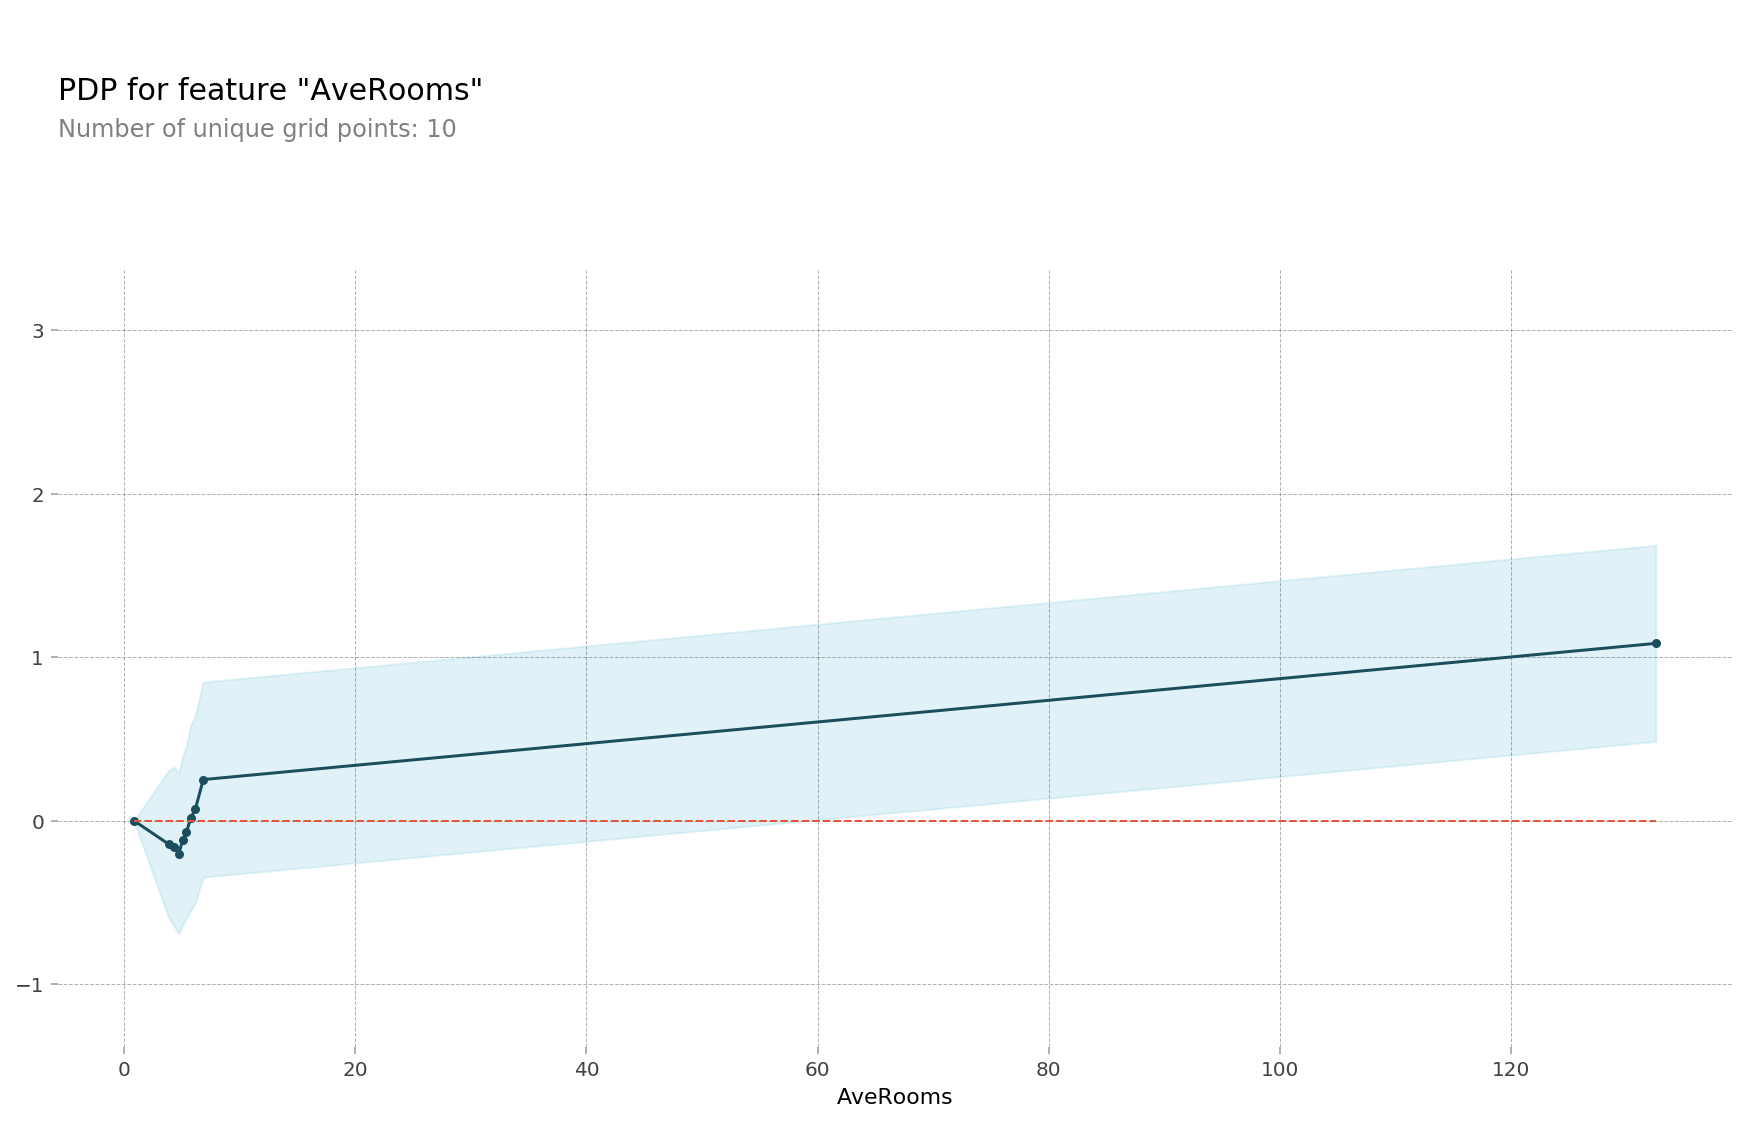

In [130]:
import sklearn
import xgboost
import shap
from sklearn.model_selection import train_test_split

shap.initjs();

df, target = shap.datasets.california()
X_train,X_test,y_train,y_test = train_test_split(df, target, test_size=0.2, random_state=2)

model = xgboost.XGBRegressor().fit(X_train, y_train)

### Draw PDP plots ###

from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'AveRooms'

isolated = pdp_isolate(
    model=model, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);


특성 AveRooms이 증가할수록 타겟값은 감소하는 경향을 확인할 수 있다.

In [128]:
X_train

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
2072   1.4817       6.0  4.443645   1.134293      1397.0  3.350120     36.77   
10600  6.9133       8.0  5.976471   1.026471       862.0  2.535294     33.68   
2494   1.5536      25.0  4.088785   1.000000       931.0  4.350467     36.60   
4284   1.5284      31.0  2.740088   1.008811       597.0  2.629956     34.10   
16541  4.0815      21.0  5.166667   1.002688      1130.0  3.037634     37.79   
...       ...       ...       ...        ...         ...       ...       ...   
1099   3.0625      20.0  5.860000   1.112000       745.0  2.980000     39.59   
18898  2.6133      49.0  5.163755   1.100437      1131.0  2.469432     38.11   
11798  4.4958      19.0  5.899767   1.074592      1206.0  2.811189     38.92   
6637   2.5750      39.0  3.591203   1.086675      2546.0  3.293661     34.16   
2575   2.2478      31.0  5.123810   1.100000      1259.0  2.997619     40.80   

       Longitude  
2072     -119.84  
10600    -117.80  
2494     -120.19  
4284     -118.32  
16541    -121.23  
...          ...  
1099     -121.90  
18898    -122.25  
11798    -121.22  
6637     -118.14  
2575     -124.13  

[16512 rows x 8 columns]

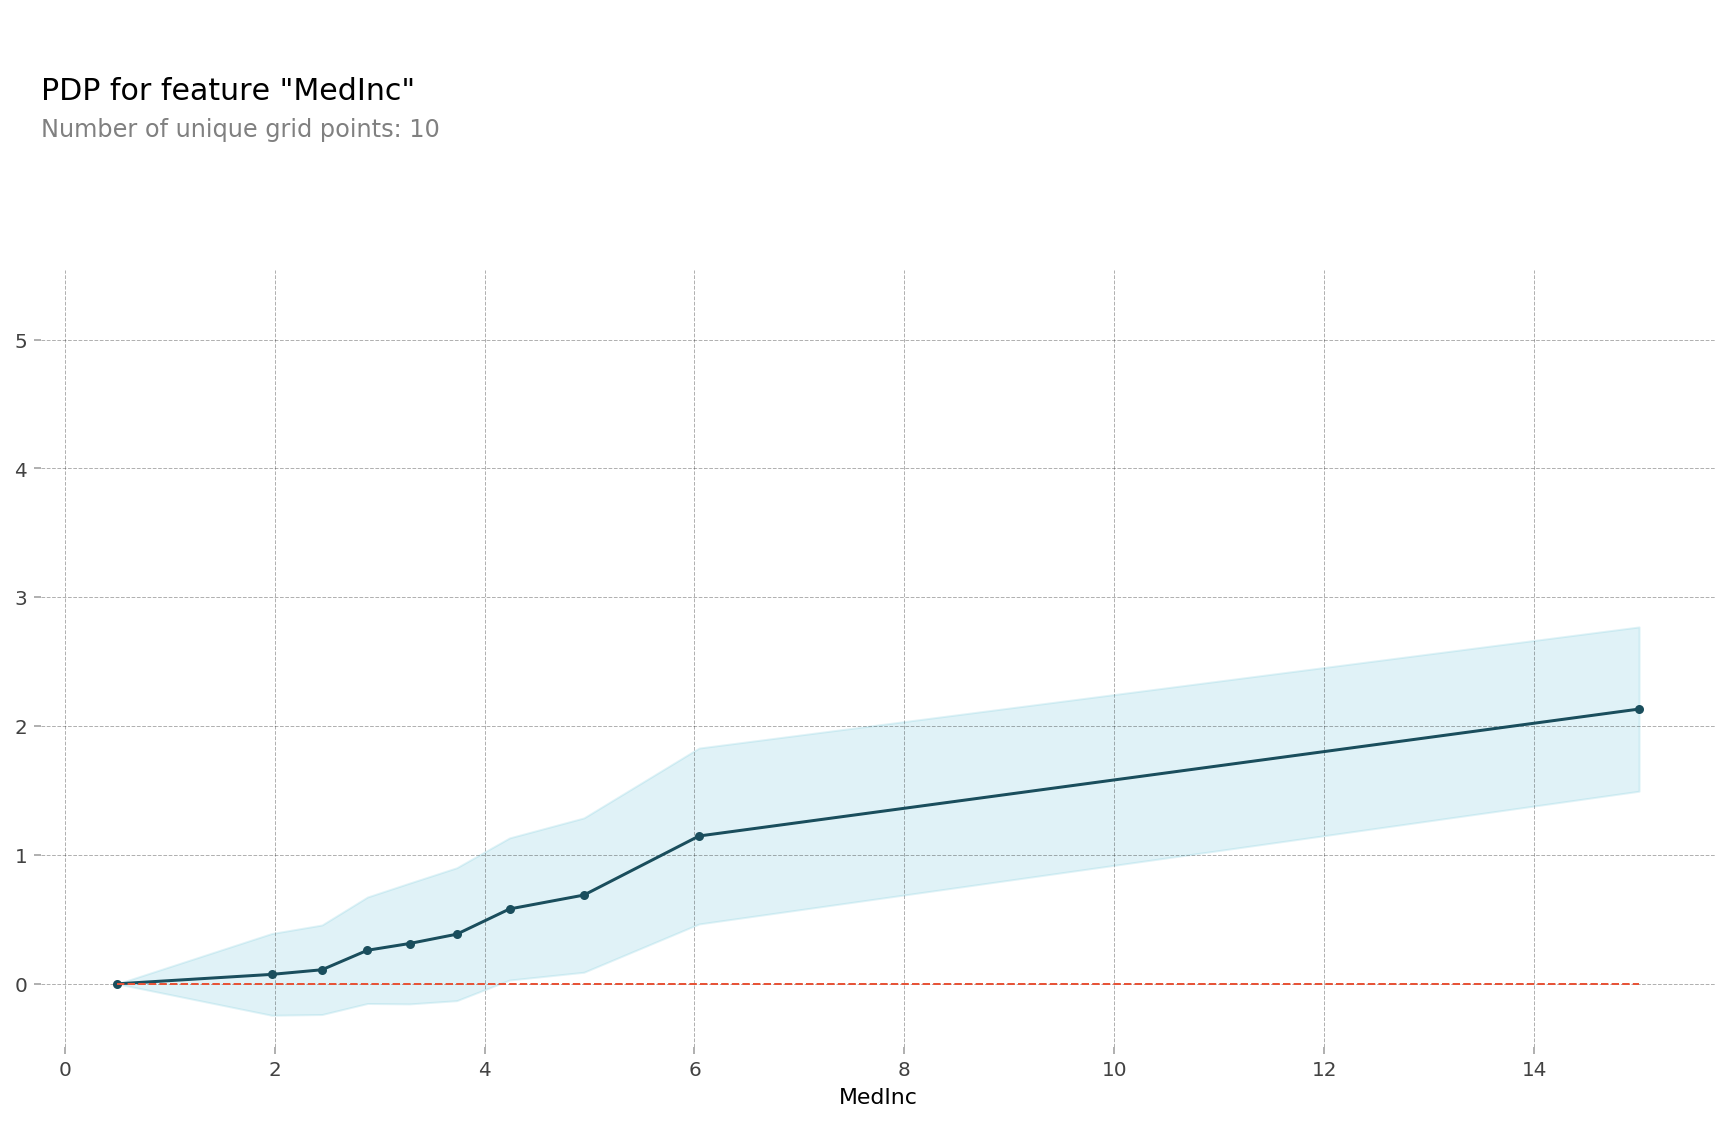

In [134]:
feature = 'MedInc'

isolated = pdp_isolate(
    model=model, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

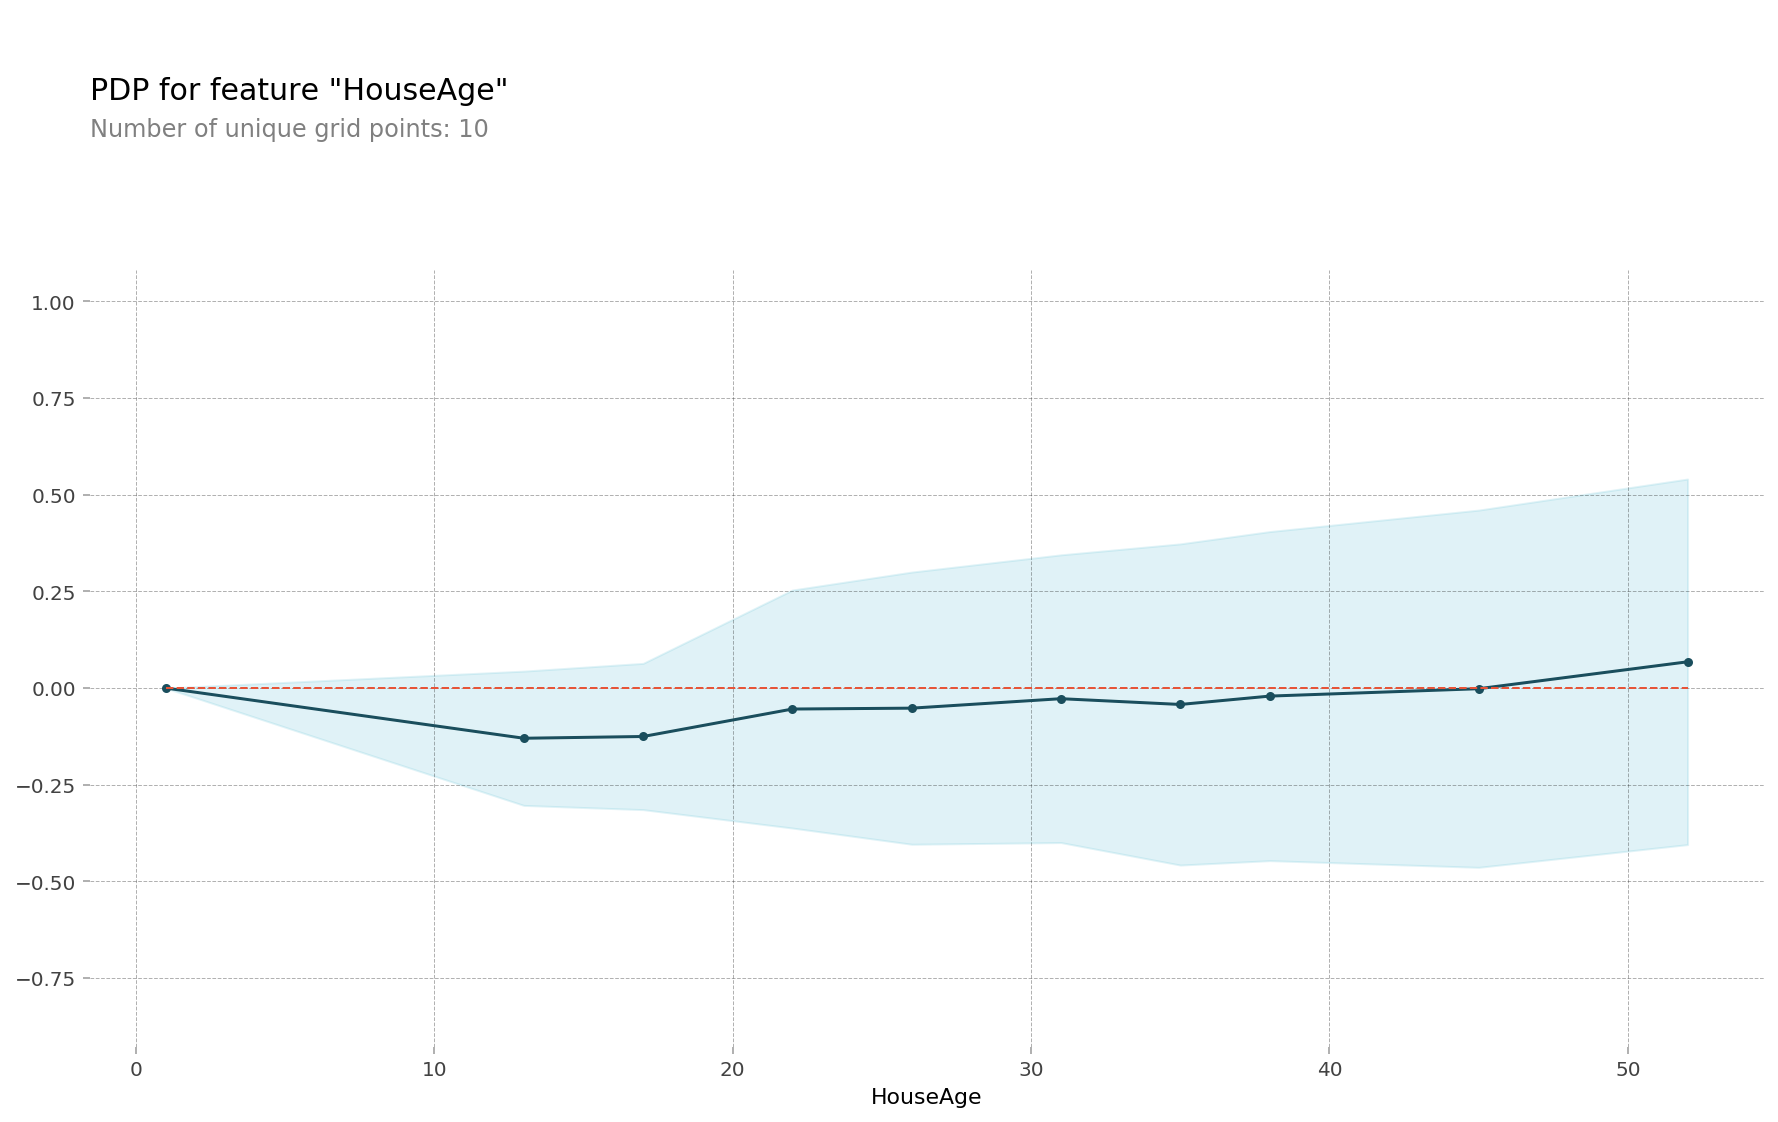

In [131]:
feature = 'HouseAge'

isolated = pdp_isolate(
    model=model, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

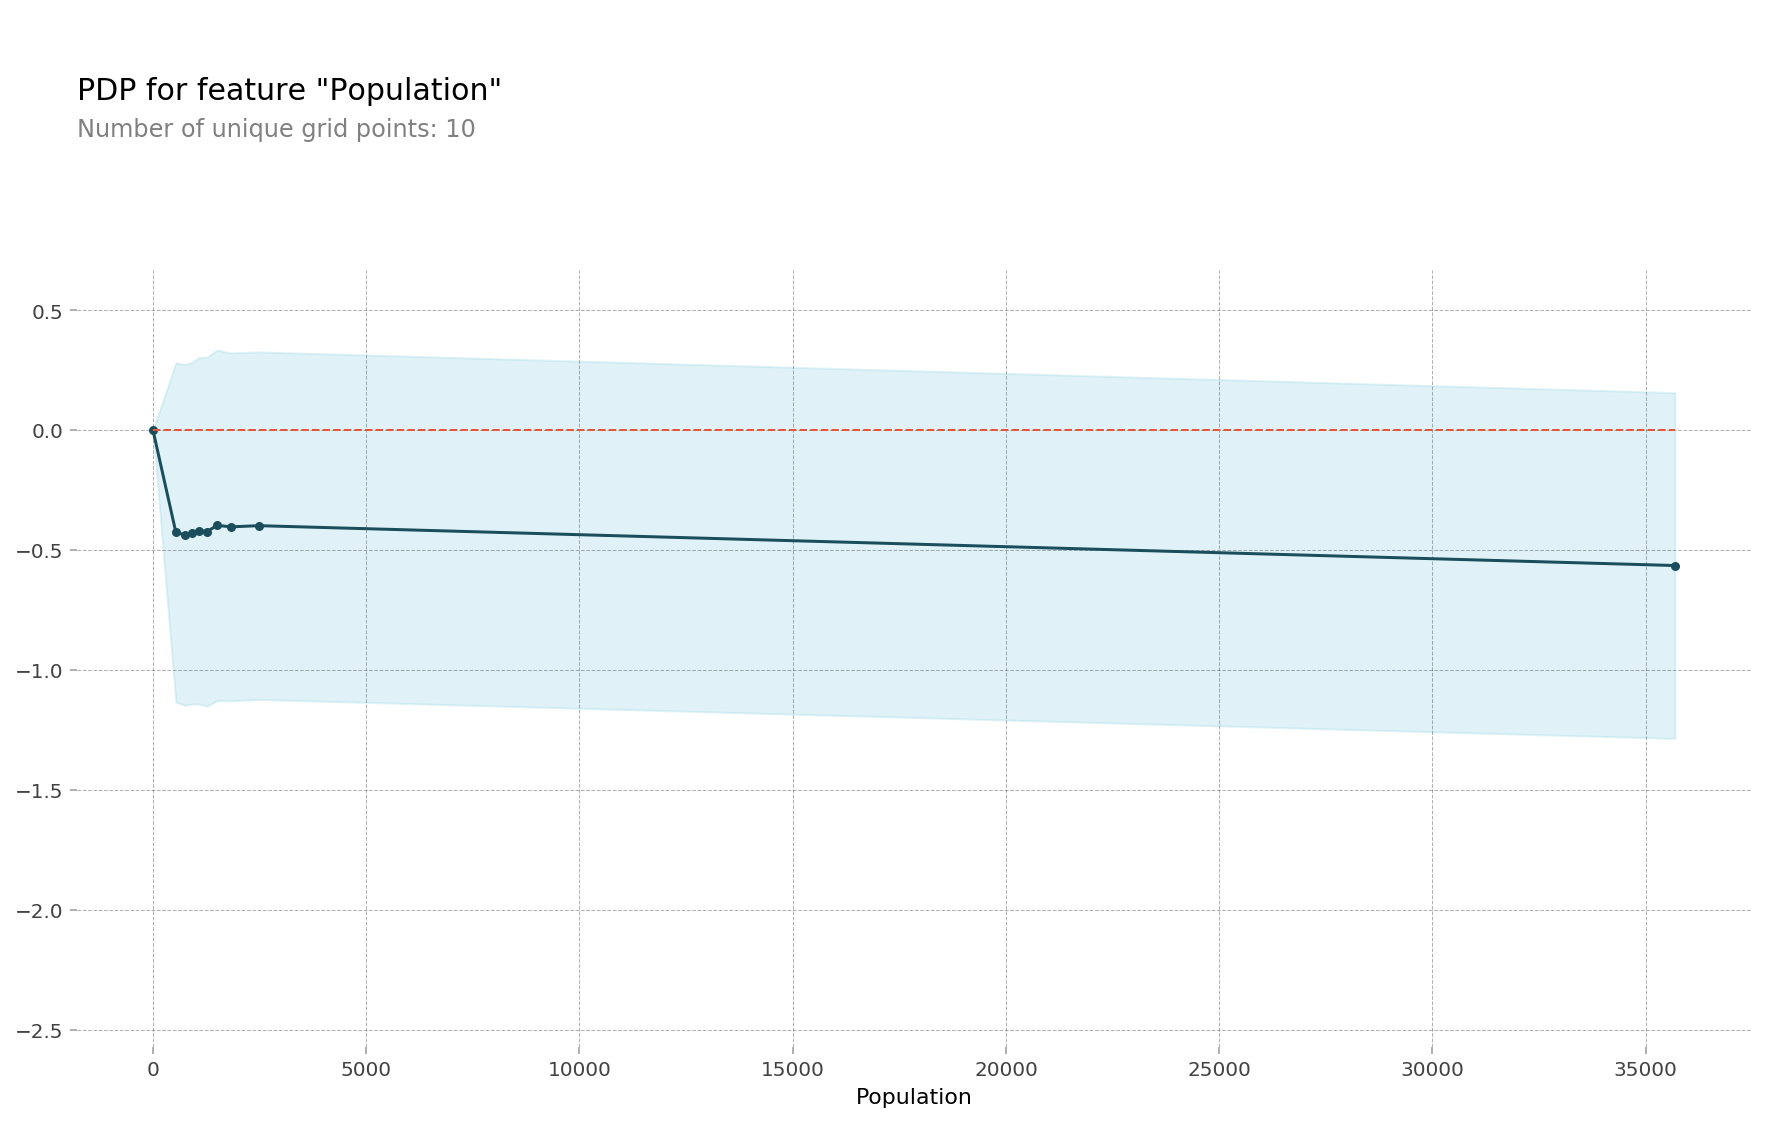

In [132]:
feature = 'Population'

isolated = pdp_isolate(
    model=model, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

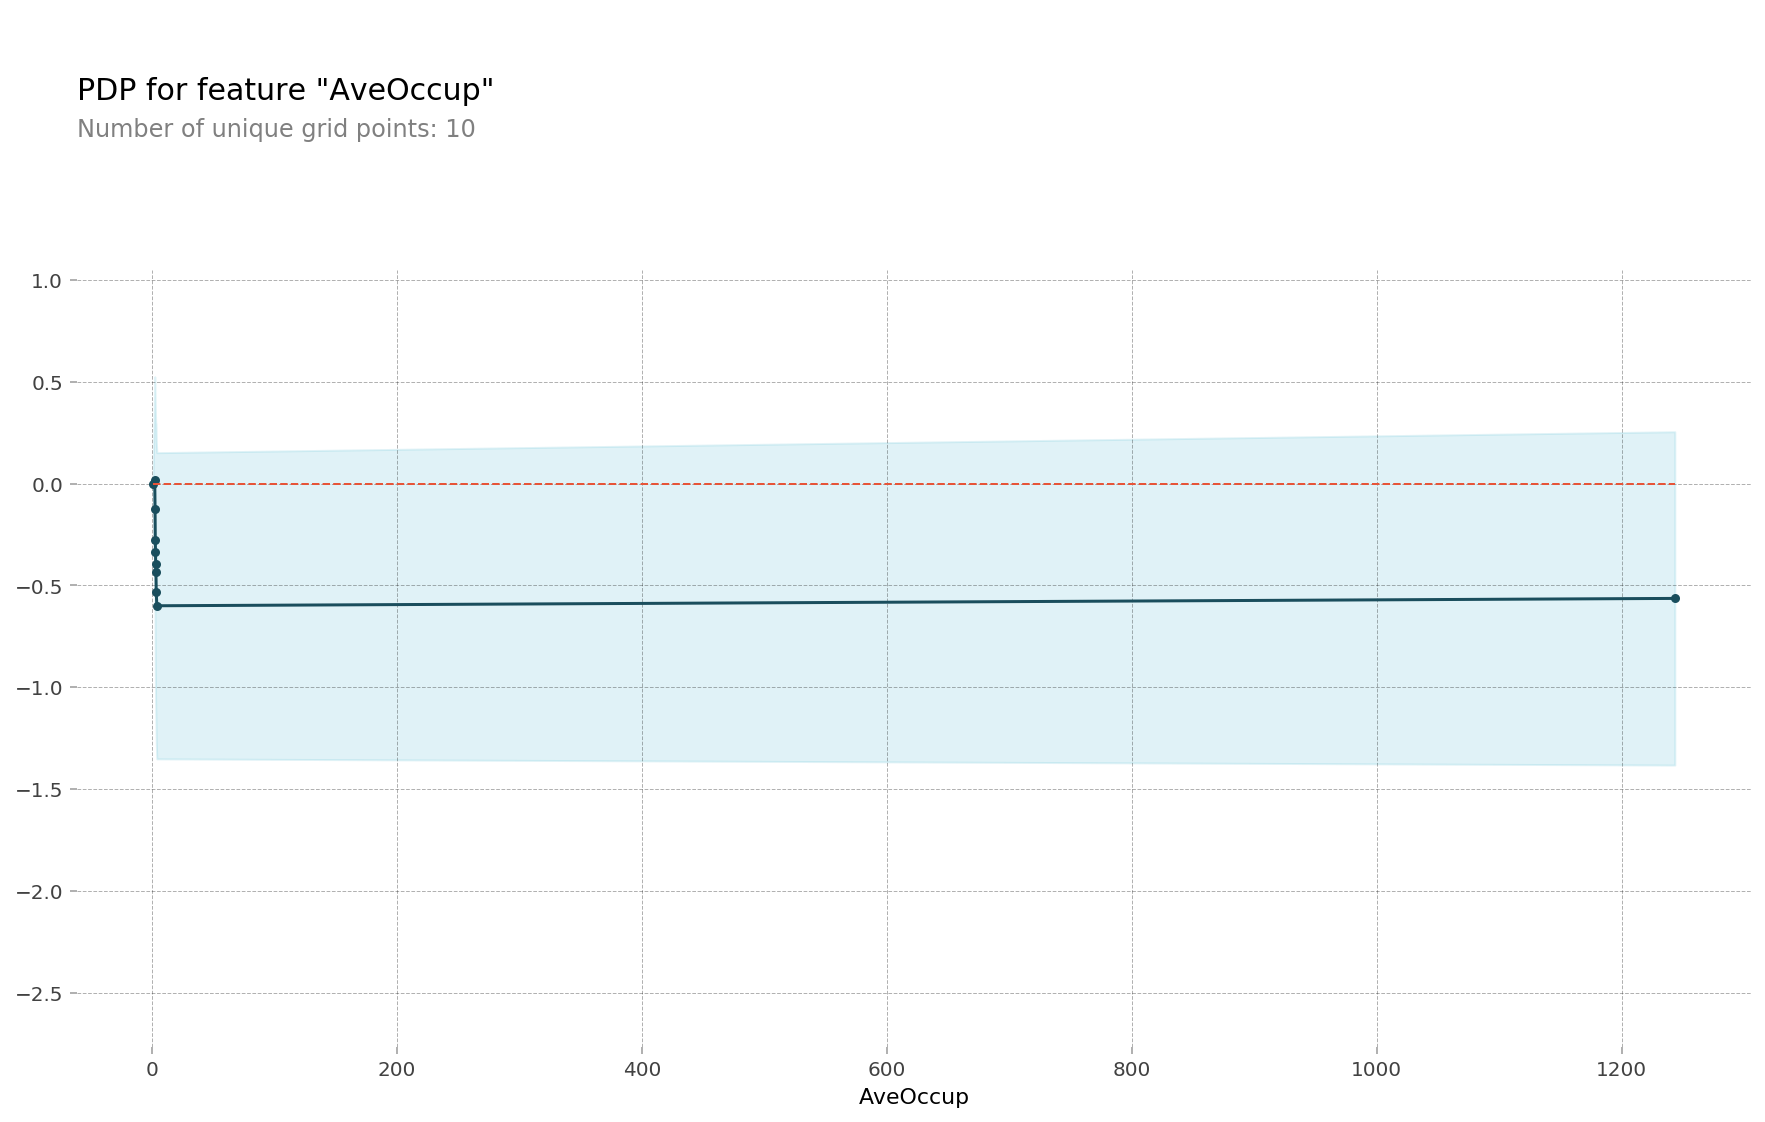

In [133]:
feature = 'AveOccup'

isolated = pdp_isolate(
    model=model, 
    dataset=X_train, 
    model_features=X_train.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

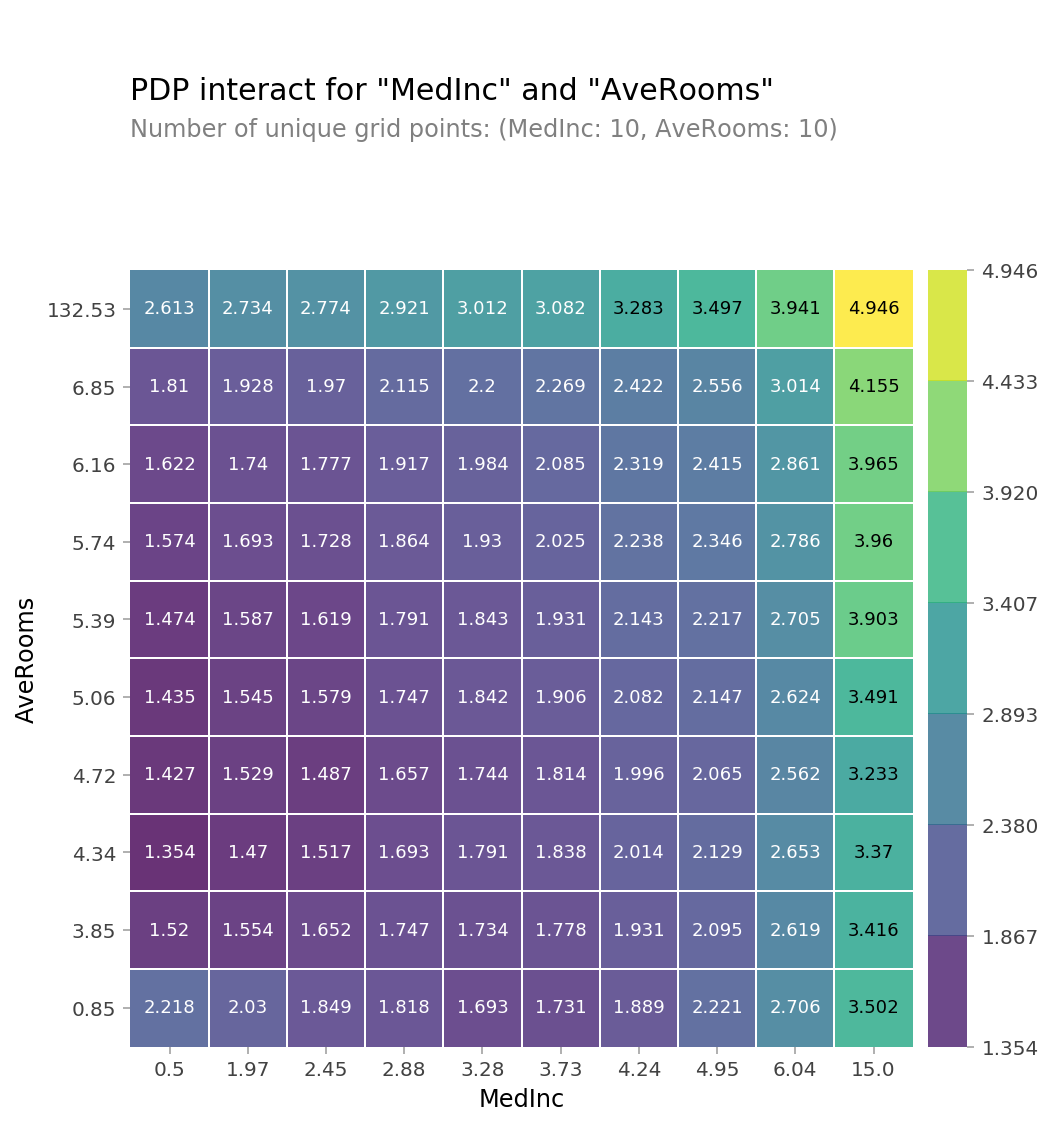

In [135]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['MedInc', 'AveRooms']

interaction = pdp_interact(
    model=model, 
    dataset=X_train,
    model_features=X_train.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);


AveRooms가 132.53 이고 MedInc가 4.946일 때 타겟값의 상승량이 가장 크다

### 모델을 분석하고 시각화 해보자

In [136]:
explainer = shap.TreeExplainer(model)

### Draw SHAP plots ###

row = X_train.iloc[[1]]
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [137]:
shap.initjs()
shap_values = explainer.shap_values(X_train.iloc[:100])
shap.force_plot(explainer.expected_value, shap_values, X_train.iloc[:100])

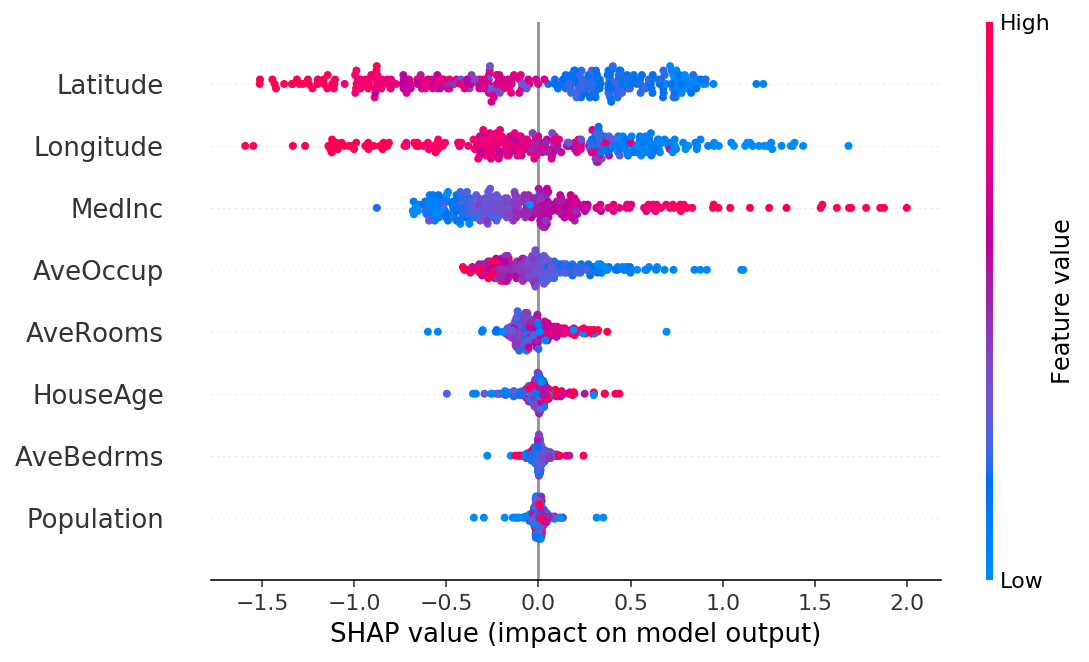

In [138]:
shap_values = explainer.shap_values(X_train.iloc[:300])
shap.summary_plot(shap_values, X_train.iloc[:300])

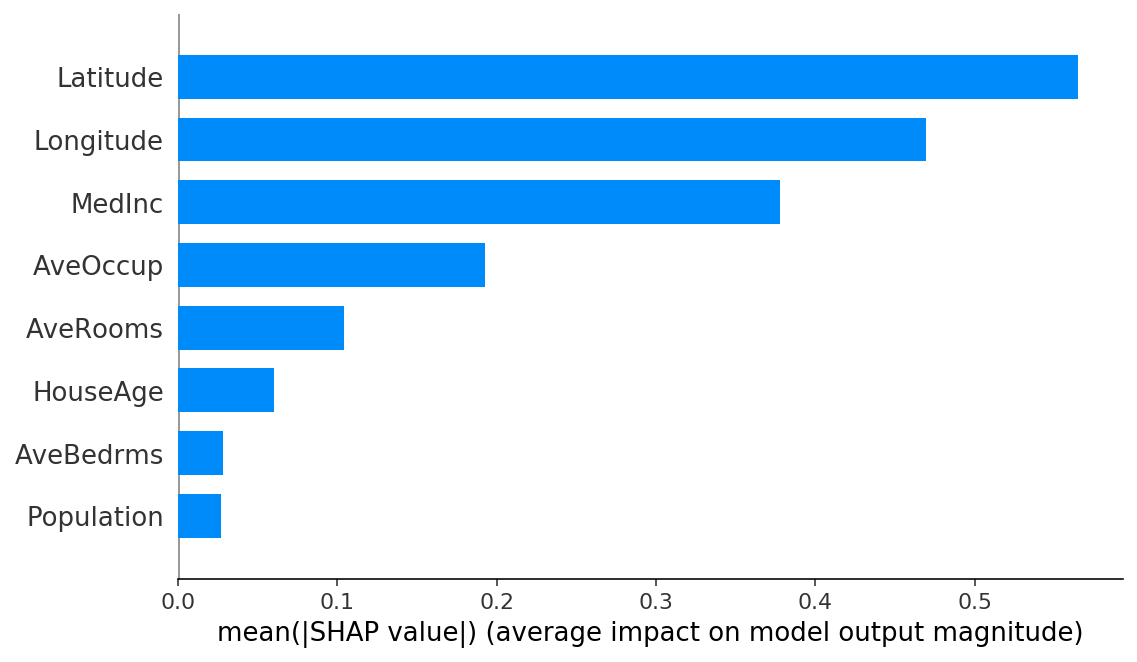

In [139]:
shap.summary_plot(shap_values, X_train.iloc[:300], plot_type="bar")